**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# A deep neural network model optimized for classifying a predefined limited set of samples

## Abstract

Over the recent increase in the availability of free data and processing power, more application areas have become available for implementing machine learning even in layman's resources. in this project, we experimented with implementing a classifier for recognizing music genres within the given data set. Although many out-of-the-box solutions exist, was this project more about implementing a classifier highly optimized for this problem and set of data. The imbalance of the categories found in given data, as well as limited training samples, added more challenge to the implementation. We tested several classifiers and implemented a deep neural network model for the genre classification. The model was then evaluated with training set, as well as with unseen data in Kaggle competition. Although the final performance of the model was mediocre at best, the process of model selection and tuning was extensive and is presented in this report, and we hope it helps others to avoid some mistakes in the future. 

## 1. Introduction

The data analysis projects goal was to design a complete machine learning solution for identifying different music genres from songs. Recognition of different music genres with machine learning algorithms is challenging. The project encouraged to try different machine learning methods to solve a real-life problem. Some of the methods have been introduced during the course but in this project, we also tried a wide range of different classification methods.

In the project, our motivation was to learn to understand the dataset and try different machine learning methods for obtaining a precise model. While doing the project we understood how important data preprocessing is to prevent overfitting happening. During the project, we tried multiple different classifiers and many of them gave only decent results. Finding a correct and stable classifier for the problem was challenging.

In the second chapter, we introduce the given data for the project. The third chapter is related to introducing methods and experiments that we used to acquire a satisfying model. The fourth chapter is about the results that we got with our most precise model and in the last chapter we present the conclusions.

#### Acknowledgements
As our implementation of the model is highly dependent on external libraries and scripts in separate python files, we do not suggest executing the notebook. We have included the source code used in the project and it can be found in the appendix. These are, however, only a collection of the most important files and we do not guarantee the successful execution of them. However, the cells should be executable if required external PyPi packages are installed and the data files are found in data path defined in `DataHandle.__init__()`, save the last two cells in section 4, which require the predictions from the model in the file. These are not provided as we did not see reason for including them.



## 2. Data

In [12]:
import numpy as np
import pandas as pd
import scipy as sp
import importlib
import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10, 10]
%matplotlib inline

from IPython.display import display, Markdown
import ipywidgets as widgets
from ipywidgets import IntProgress

## 2.1 Data analysis

For the project, we obtained training and testing data. Testing data consist from 4363 labeled songs and the test data from 6544 unlabeled songs. There are songs from 10 different genres and the songs have 264 features which are composed of timbre, pitch and, rhythm. These three components of music can be described with rhythm pattern, chroma and Mel Frequency Cepstral Coefficients (MFCC). Feature vector contains 168 values for of rhythm pattern, 48 values for chroma and 48 values for MFCCs. 

List of different genres in the dataset with label number:

1. Pop_Rock

2. Electronic

3. Rap

4. Jazz

5. Latin

6. RnB

7. International

8. Country

9. Reggae

10. Blues


When creating the variables, we assume the following structure of the given feature vectors

*Table 1: Feature vector breakdown:*

mean | median | var | kurt | skew | min | max | mean | std | min | max | mean | std | min | max
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
Rhythm | Rhythm | Rhythm | Rhythm | Rhythm | Rhythm | Rhythm | Chroma | Chroma | Chroma | Chroma | MFCCs | MFCCs | MFCCs | MFCCs
0-23 | 24-47 | 48-71 | 72-95 | 96-119 | 120-143 | 144-167 | 168-179 | 180-191 | 192-203 | 204-215 | 216-227 | 228-239 | 240-251 | 252-263

We assigned feature labels for each feature based on these definitions. This was to ease the analysis and development later.


As we would require repetitive loading of the data, we implemented a class for handling the data. the source can be found in Appendix A1.

In [3]:
# Init the DataHandle
dataHandle = DataHandle()
# Load labeled data:
d_train = dataHandle.load_train_data(
    labels=True, feature_labels=True,
    normalise=False, balanced=False)
# Load unlabeled data:
d_test = dataHandle.load_test_data(
    labels=True, feature_labels=True, 
    normalise=False)
# Form a DataFrame with both labeled and unlabeled data:
data = pd.concat([d_train, d_test])

0 10
(6544,) (6544, 264)


#### 2.1.1 Label distribution

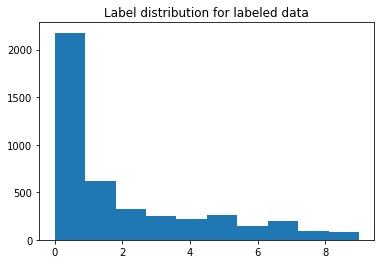

In [4]:
plt.hist(d_train.Label), plt.title('Label distribution for labeled data')
plt.show()

---
#### 2.1.2  Feature inspection

### Rhythm bands

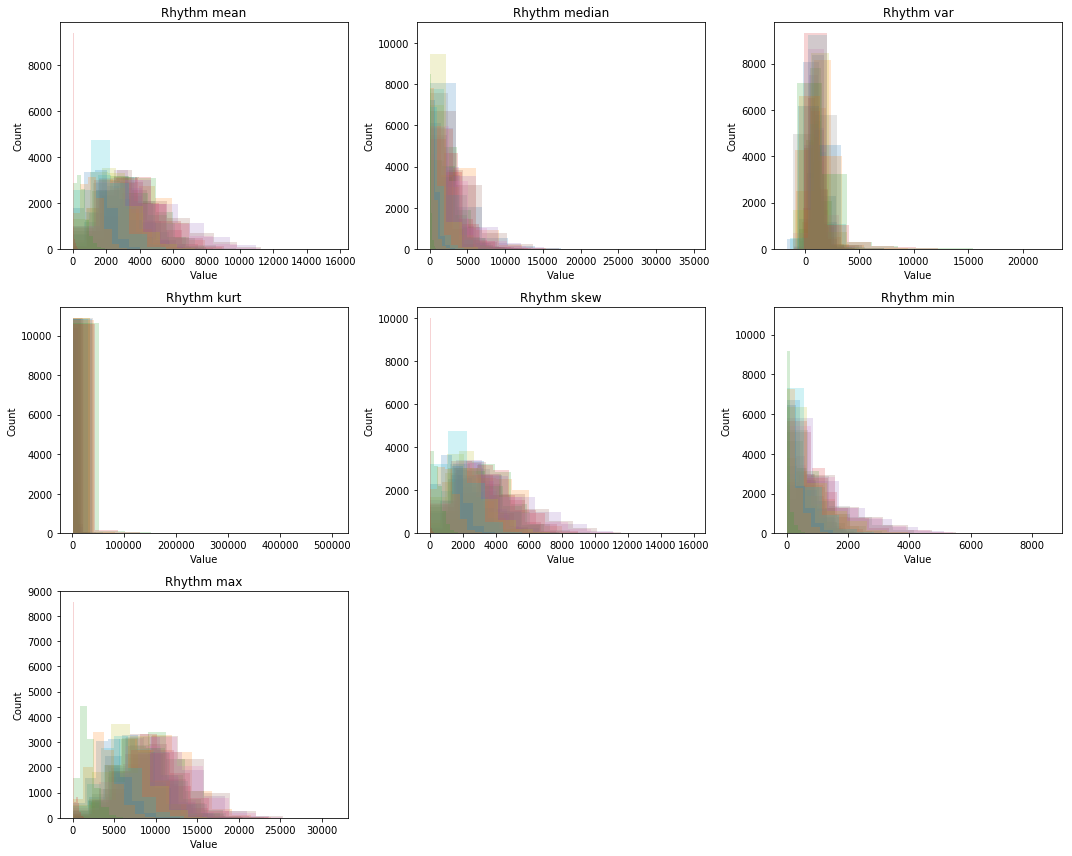

In [5]:
# Rhythm
display(Markdown('### Rhythm bands'))
plt.figure(1, figsize=(15,12))
for p, s_type in enumerate(dataHandle.R_types):
    plt.subplot(3,3,p+1)
    for i in range(dataHandle.R_bands):
        plt.hist(data['R_'+s_type+'_'+str(i)], alpha=0.2)
        plt.ylabel('Count'), plt.xlabel('Value')
        plt.title('Rhythm '+s_type)
plt.tight_layout()
plt.show()

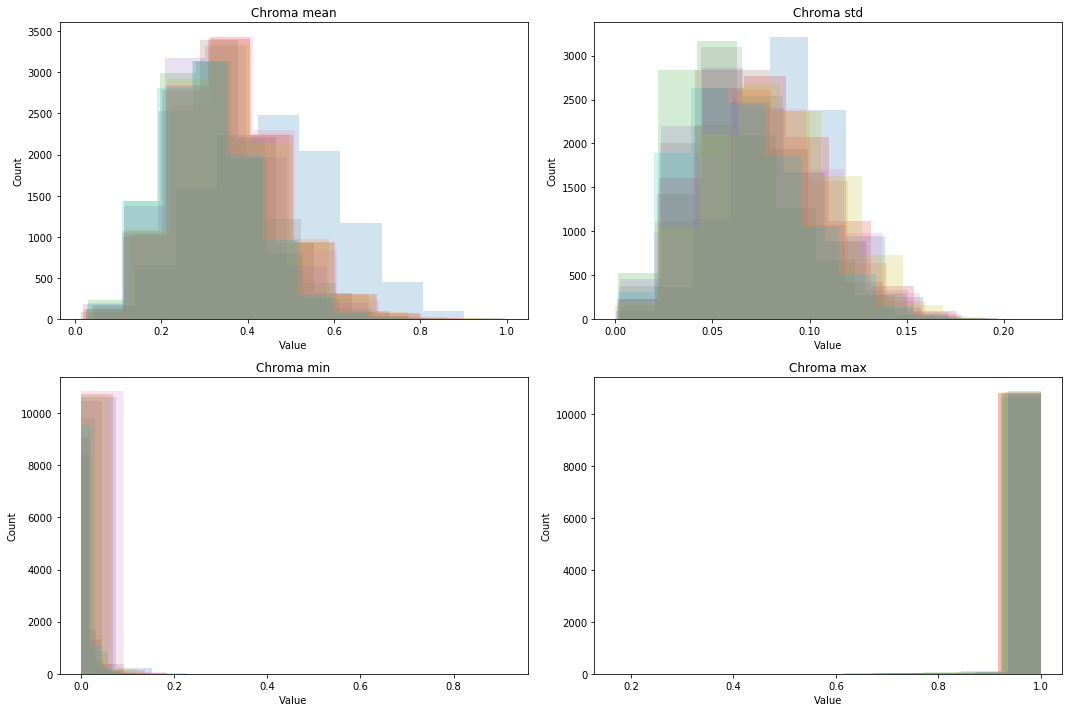

In [6]:
# Chroma bands
plt.figure(1, figsize=(15,10))
for p, s_type in enumerate(dataHandle.C_types):
    plt.subplot(2,2,p+1)
    for i in range(1,11):
        plt.hist(data['C_'+s_type+'_'+str(i)], alpha=0.2)
        plt.ylabel('Count'), plt.xlabel('Value')
        plt.title('Chroma '+s_type)
plt.tight_layout()
plt.show()

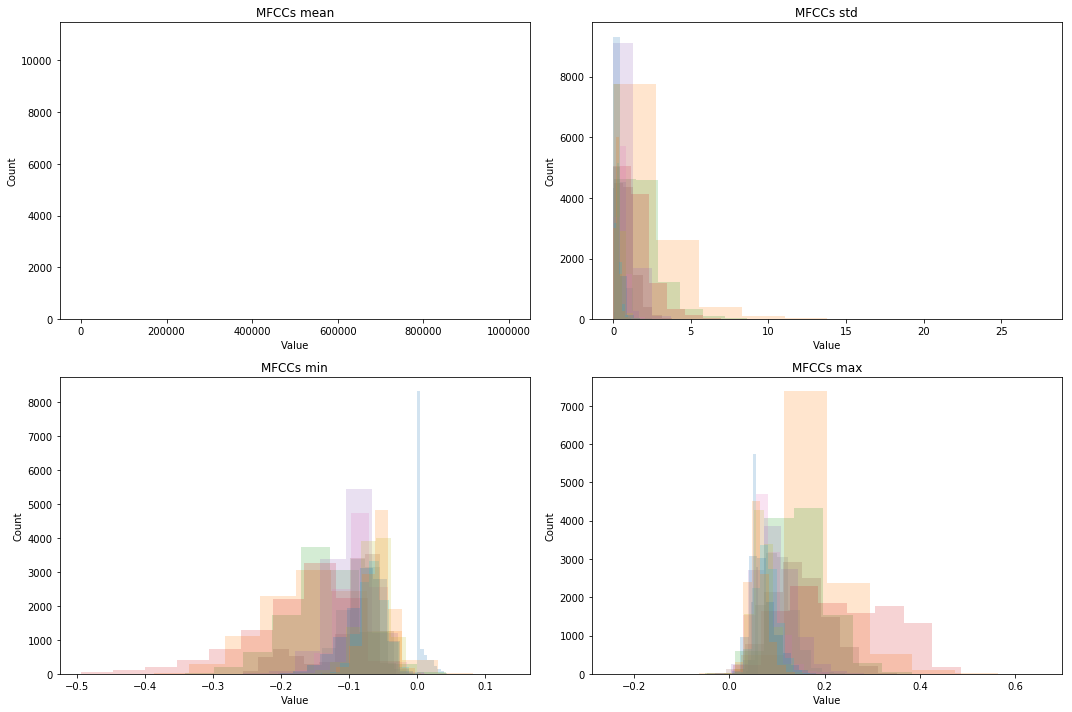

In [7]:
# MFCCs
plt.figure(1, figsize=(15,10))
for p, s_type in enumerate(dataHandle.M_types):
    plt.subplot(2,2,p+1)
    for i in range(dataHandle.M_coefs):
        plt.hist(data['M_'+s_type+'_'+str(i)], alpha=0.2)
        plt.ylabel('Count'), plt.xlabel('Value')
        plt.title('MFCCs '+s_type)
plt.tight_layout()
plt.show()

The MFCCs mean is not showing anything, inspect the couple first columns:

In [8]:
data.loc[:, 'M_mean_0':'M_mean_11'].head()

,M_mean_0,M_mean_1,M_mean_2,M_mean_3,M_mean_4,M_mean_5,M_mean_6,M_mean_7,M_mean_8,M_mean_9,M_mean_10,M_mean_11
0,1000000.0,1000000.0,1000000.0,1000000.0,0.001894,-0.002000,0.001301,0.001159,-0.006528,-0.001903,0.001681,0.009920
1,1000000.0,1000000.0,1000000.0,1000000.0,-0.002680,-0.027749,0.027858,0.002513,0.014589,0.007545,-0.002405,0.015146
2,1000000.0,1000000.0,1000000.0,1000000.0,-0.001637,0.006803,-0.001520,-0.006899,0.001273,-0.006530,-0.000797,-0.001442
3,1000000.0,1000000.0,1000000.0,1000000.0,-0.026825,-0.023088,-0.003284,-0.003447,-0.004121,0.002818,0.001818,-0.002063
4,1000000.0,1000000.0,1000000.0,1000000.0,-0.014689,-0.022217,-0.009048,0.001094,0.016120,0.004603,0.000799,0.009655


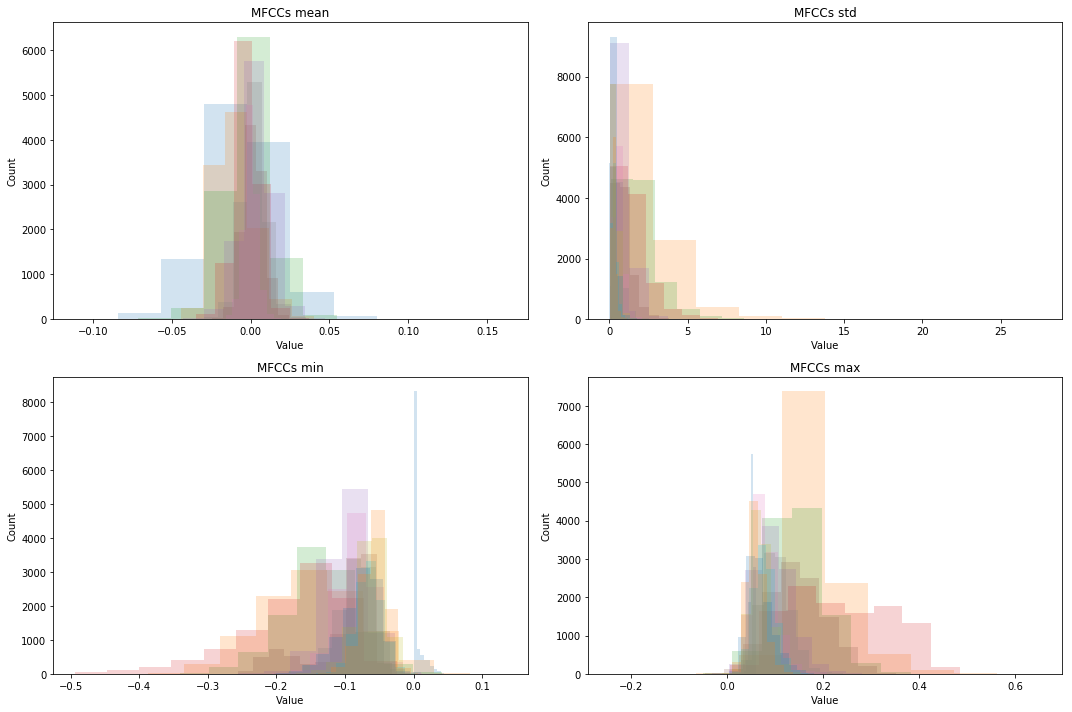

In [10]:
# Repeaet the MFCCs plot with assumed anomalies removed
plt.figure(1, figsize=(15,10))
for p, s_type in enumerate(dataHandle.M_types):
    plt.subplot(2,2,p+1)
    for i in range(dataHandle.M_coefs):
        tag = 'M_'+s_type+'_'+str(i)
        # Skip features which are anomalies (based on analysis notebook)
        if tag in ['M_mean_0', 'M_mean_1', 'M_mean_2', 'M_mean_3']:
            continue
        plt.hist(data[tag], alpha=0.2)
        plt.ylabel('Count'), plt.xlabel('Value')
        plt.title('MFCCs '+s_type)
plt.tight_layout()
plt.show()


#### 2.1.3 Scatter inspection


In [13]:
lbls_for = dataHandle.labels_for
R_train = d_train.loc[:, d_train.columns.isin(list(itertools.chain(*dataHandle.R_type_labels.values())))]
R_test = d_test.loc[:, d_test.columns.isin(list(itertools.chain(*dataHandle.R_type_labels.values())))]

R_mean_train = R_train.loc[:, R_train.columns.isin(lbls_for('R', 'mean'))].values.tolist()
R_mean_test  = R_test.loc[:, R_test.columns.isin(lbls_for('R', 'mean'))].values.tolist()
R_med_train  = R_train.loc[:, R_train.columns.isin(lbls_for('R', 'median'))].values.tolist()
R_med_test   = R_test.loc[:, R_test.columns.isin(lbls_for('R', 'median'))].values.tolist()
R_var_train  = R_train.loc[:, R_train.columns.isin(lbls_for('R', 'var'))].values.tolist()
R_var_test   = R_test.loc[:, R_test.columns.isin(lbls_for('R', 'var'))].values.tolist()
R_kurt_train = R_train.loc[:, R_train.columns.isin(lbls_for('R', 'kurt'))].values.tolist()
R_kurt_test  = R_test.loc[:, R_test.columns.isin(lbls_for('R', 'kurt'))].values.tolist()
R_min_train  = R_train.loc[:, R_train.columns.isin(lbls_for('R', 'min'))].values.tolist()
R_min_test   = R_test.loc[:, R_test.columns.isin(lbls_for('R', 'min'))].values.tolist()
R_max_train  = R_train.loc[:, R_train.columns.isin(lbls_for('R', 'max'))].values.tolist()
R_max_test   = R_test.loc[:, R_test.columns.isin(lbls_for('R', 'max'))].values.tolist()
R_skew_train = R_train.loc[:, R_train.columns.isin(lbls_for('R', 'skew'))].values.tolist()
R_skew_test  = R_test.loc[:, R_test.columns.isin(lbls_for('R', 'skew'))].values.tolist()

C_train = d_train.loc[:, d_train.columns.isin(list(itertools.chain(*dataHandle.C_type_labels.values())))]
C_test = d_test.loc[:, d_test.columns.isin(list(itertools.chain(*dataHandle.C_type_labels.values())))]

C_mean_train = C_train.loc[:, C_train.columns.isin(lbls_for('C', 'mean'))].values.tolist()
C_mean_test  = C_test.loc[:, C_test.columns.isin(lbls_for('C', 'mean'))].values.tolist()
C_sd_train   = C_train.loc[:, C_train.columns.isin(lbls_for('C', 'std'))].values.tolist()
C_sd_test    = C_test.loc[:, C_test.columns.isin(lbls_for('C', 'std'))].values.tolist()
C_min_train  = C_train.loc[:, C_train.columns.isin(lbls_for('C', 'min'))].values.tolist()
C_min_test   = C_test.loc[:, C_test.columns.isin(lbls_for('C', 'min'))].values.tolist()
C_max_train  = C_train.loc[:, C_train.columns.isin(lbls_for('C', 'max'))].values.tolist()
C_max_test   = C_test.loc[:, C_test.columns.isin(lbls_for('C', 'max'))].values.tolist()

M_train = d_train.loc[:, d_train.columns.isin(list(itertools.chain(*dataHandle.M_type_labels.values())))]
M_test = d_test.loc[:, d_test.columns.isin(list(itertools.chain(*dataHandle.M_type_labels.values())))]

M_mean_train = M_train.loc[:, M_train.columns.isin(lbls_for('M', 'mean'))].values.tolist()
M_mean_test  = M_test.loc[:, M_test.columns.isin(lbls_for('M', 'mean'))].values.tolist()
M_sd_train   = M_train.loc[:, M_train.columns.isin(lbls_for('M', 'std'))].values.tolist()
M_sd_test    = M_test.loc[:, M_test.columns.isin(lbls_for('M', 'std'))].values.tolist()
M_min_train  = M_train.loc[:, M_train.columns.isin(lbls_for('M', 'min'))].values.tolist()
M_min_test   = M_test.loc[:, M_test.columns.isin(lbls_for('M', 'min'))].values.tolist()
M_max_train  = M_train.loc[:, M_train.columns.isin(lbls_for('M', 'max'))].values.tolist()
M_max_test   = M_test.loc[:, M_test.columns.isin(lbls_for('M', 'max'))].values.tolist()

def text_minmax(b1, b2, tagb, r1, r2, tagr):
    """ Plot the two datas in black and red, higlight largest and smallest of sets """
    sb1, sb2, lb1, lb2 = np.min(b1), np.min(b2), np.max(b1), np.max(b2)
    sr1, sr2, lr1, lr2 = np.min(r1), np.min(r2), np.max(r1), np.max(r2)
    print(f'{tagb} mins: {sb1}, {sb2}\n{tagb} maxs: {lb1}, {lb2}\n{tagr} mins: {sr1}, {sr2}\n{tagr} maxs: {lr1}, {lr2}')

**Rhythm**

mean mins: 1.0659999999999998, 1.0659999999999998
mean maxs: 15682.0, 14008.0
med mins: 0.0, 0.0
med maxs: 34783.0, 30418.0
var mins: -1573.8, -1687.8
var maxs: 20544.0, 22423.0
kurt mins: 1000.0, 1000.0
kurt maxs: 442280.0, 505300.0
min mins: 1.0659999999999998, 1.0659999999999998
min maxs: 8544.2, 7861.9
max mins: 1.0659999999999998, 1.0659999999999998
max maxs: 31604.0, 31465.0
skew mins: 1.0659999999999998, 1.0659999999999998
skew maxs: 15880.0, 13909.0
var mins: -1573.8, -1687.8
var maxs: 20544.0, 22423.0


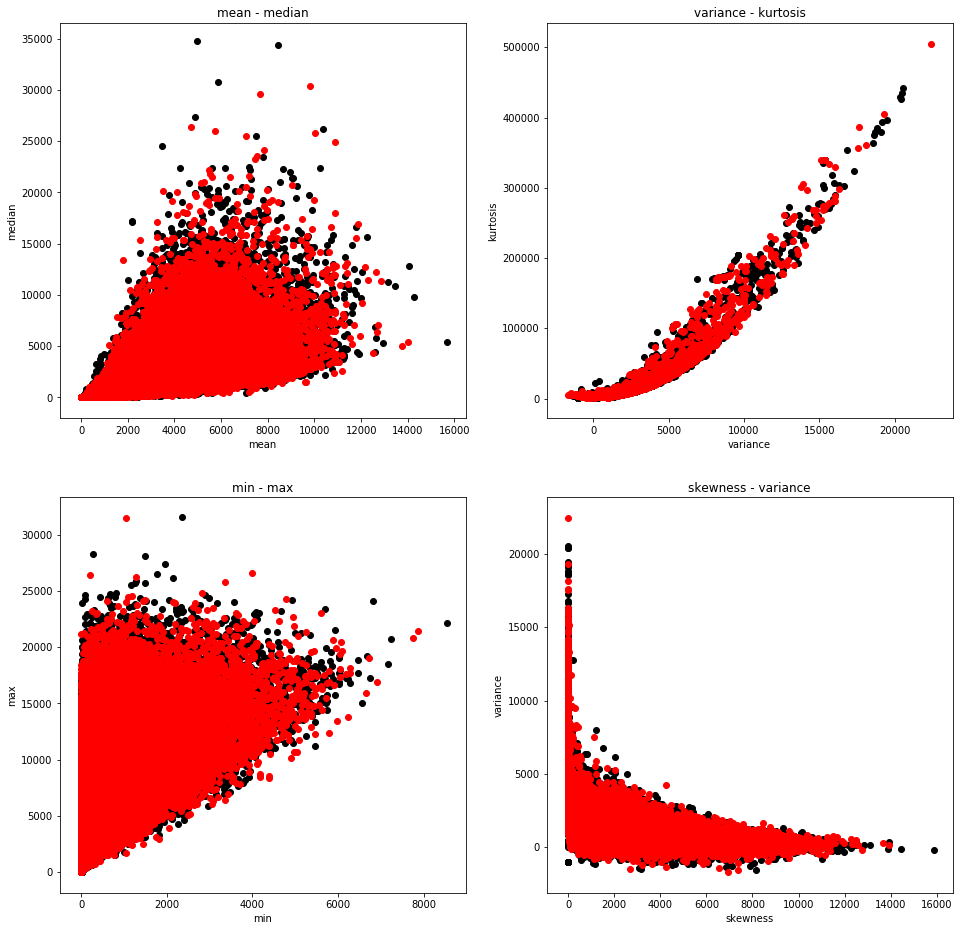

In [14]:
# Rhythm:
plt.figure(figsize=(16,16))
plt.subplot(221), plt.title('mean - median'), plt.xlabel('mean'), plt.ylabel('median')
plt.scatter(R_mean_test, R_med_test, c='k')
plt.scatter(R_mean_train, R_med_train, c='r')
text_minmax(R_mean_test, R_mean_train, 'mean', R_med_test, R_med_train, 'med')

plt.subplot(222), plt.title('variance - kurtosis'), plt.xlabel('variance'), plt.ylabel('kurtosis')
plt.scatter(R_var_test, R_kurt_test, c='k')
plt.scatter(R_var_train, R_kurt_train, c='r')
text_minmax(R_var_test, R_var_train, 'var', R_kurt_test, R_kurt_train, 'kurt')

plt.subplot(223), plt.title('min - max'), plt.xlabel('min'), plt.ylabel('max')
plt.scatter(R_min_test, R_max_test, c='k')
plt.scatter(R_min_train, R_max_train, c='r')
text_minmax(R_min_test, R_min_train, 'min', R_max_test, R_max_train, 'max')

plt.subplot(224), plt.title('skewness - variance'), plt.xlabel('skewness'), plt.ylabel('variance')
plt.scatter(R_skew_test, R_var_test, c='k')
plt.scatter(R_skew_train, R_var_train, c='r')
text_minmax(R_skew_test, R_skew_train, 'skew', R_var_test, R_var_train, 'var')
plt.show()

The scatters are relatively nice. We decided to cap the mean, median, variance and curtosis a bit.

**Chroma**

mean mins: 0.013947, 0.019899
mean maxs: 0.99916, 0.98713
sd mins: 3.9855e-05, 0.0008657999999999999
sd maxs: 0.21914, 0.21398000000000003
min mins: 0.0, 0.0
min maxs: 0.601, 0.9129999999999999
max mins: 0.18600000000000003, 0.17
max maxs: 1.0, 1.0


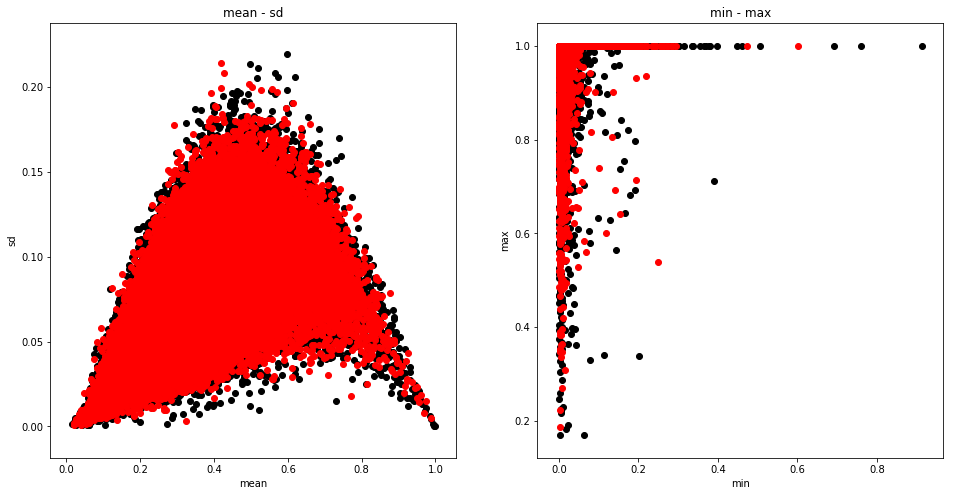

In [15]:
# Chroma
plt.figure(figsize=(16,8))
plt.subplot(121), plt.title('mean - sd'), plt.xlabel('mean'), plt.ylabel('sd')
plt.scatter(C_mean_test, C_sd_test, c='k')
plt.scatter(C_mean_train, C_sd_train, c='r')
text_minmax(C_mean_test, C_mean_train, 'mean', C_sd_test, C_sd_train, 'sd')

plt.subplot(122), plt.title('min - max'), plt.xlabel('min'), plt.ylabel('max')
plt.scatter(C_min_test, C_max_test, c='k')
plt.scatter(C_min_train, C_max_train, c='r')
text_minmax(C_min_train, C_min_test, 'min', C_max_train, C_max_test, 'max')
plt.show()

As with Rhythm, the Chroma distributions are nicely condense and decided not to limit any of the variables.

**MFCCs**

mean mins: -0.10919000000000001, -0.11135999999999999
mean maxs: 0.10725, 0.1619
sd mins: 0.015074, 0.023749
sd maxs: 12.436, 6.9195
min mins: -0.25815, -0.29402
min maxs: 0.058660000000000004, 0.086453
max mins: -0.046172000000000005, -0.03128
max maxs: 0.35241, 0.34847


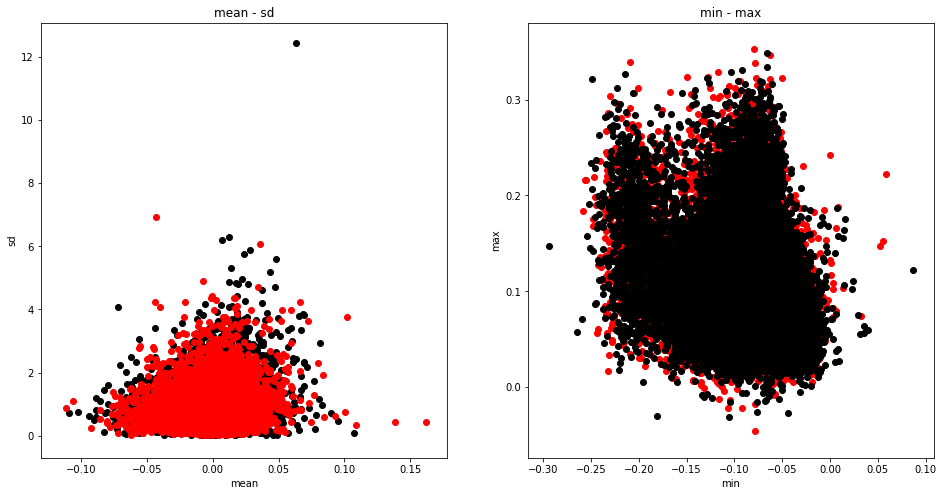

In [16]:
# MFCCs
plt.figure(figsize=(16,8))
plt.subplot(121), plt.title('mean - sd'), plt.xlabel('mean'), plt.ylabel('sd')
plt.scatter(M_mean_test, M_sd_test, c='k')
plt.scatter(M_mean_train, M_sd_train, c='r')
text_minmax(M_mean_test, M_mean_train, 'mean', M_sd_test, M_sd_train, 'sd')

plt.subplot(122), plt.title('min - max'), plt.xlabel('min'), plt.ylabel('max')
plt.scatter(M_min_train, M_max_train, c='r')
plt.scatter(M_min_test, M_max_test, c='k')
text_minmax(M_min_train, M_min_test, 'min', M_max_train, M_max_test, 'max')
plt.show()

With the MFCCs, however, we can see the definite outlier in standard deviation. We removed that by capping the standard deviation of MFCCs (for all coefficeints) to 6.

#### 2.1.4 Class inspection
We also analysed the data with simple pair-wise plots for some obvious definitions between the classes. The cells would ahve been too complicated to add here, but an example is provided in Video 1. The conclusion from this analysis was, that the data was so complex dimension wise, that it could not be effectively classified with simple linear regression.

![](https://image.ibb.co/mkW7V0/classes.gif)

## 2.2 Data preprocessing
As seen in section 2.1, the data needed some preprocessing. Most of the classifier models require, or perform better with normalized values. Moreover, the possible anomalies might distort the model.

To ensure the best fit, we cleaned the both labeled and unlabeled data based on the analysis on section 2.1. We started by removing the first four coefficient features for MFCCs mean statistic as they contained no information. Next, we removed the detected outliers by capping the maximum and minimum values to the ranges presented in section 2.1.2 This way we lost no information or samples. The selected lower and upper bounds were selected as:

```json
        caps = {
            'Rhythm': {
                'mean': (1, 14500),
                'median': (0, 30000),
                'kurt': (1000, 500000),
                'skew': (1, 15000),
                'min': (1, 8000),
                'max': (1, 31500),
                'var': (-2000, 20000)
            },
            'Chroma': {
                'mean': (0, 1),
                'std': (0, 1),
                'min': (0, 0.6),
                'max': (0, 1),
            },
            'MFCCs': {
                'mean': (-1, 1),
                'std': (0, 6),
                'min': (-1, 1),
                'max': (-1, 1),
            }
        }
```

Moreover, a similar transformation could be performed for any unseen data. We then normalized the values for each feature to a range [0-1] based on their maximum and minimum values feature wise.

To summarise, the steps for preprocessing the data were the following:
  1. Remove columns 216, 217, 218 and 219 (anomalies)
  2. Remove outliers with capping
  3. Normalize the data to a range [0-1], feature wise.
  3. Add label `-1` for the unlabeled samples.
  
We then saved the clean data for labeled and unlabeled data to be later accessed with `DataHandle`. The source code for cleaning the data can be found in Appendix A1 in `DataHandle.clean_data()`

## 3. Methods and experiments

As shown in the section 2, the data was a relatively scarce resource. Therefore the need for good data handling methods was required. Moreover, more stress on this project was put onto the selection and tuning of the classification model. This section describes the process of data handling, as well as selecting and tuning the model. The process development can be seen in Figure 1.

![](https://image.ibb.co/gh2SDL/Approach.png)

*Figure 1: Process timeline*

### 3.1 Model comparison 
One of the biggest problems in machine learning is the ambiguity of which method to use to solve the problem. Thankfully, multiple solutions are already available for generic use. To evaluate the best type of classifier for this task, we decided to test the 11 different classifier available at sklearn [1]. 

We used the default settings on most of the classifiers and trained them with a training and testing set extracted from the train data. We then compared their micro- and macro accuracy, and training time. The parameter changes we made to the classifiers were iterative, based on what we saw to be the best. The*accuracy* in the generated tables below describes the same accuracy as used in the Kaggle competition. The *balanced accuracy* is the accuracy weighted with the classes, and hence describes the average accuracy of the classification.

In [19]:
# Evaluation:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

In [20]:
def display_metrics(tag, labels, predictions, train_time=None):
    acc = accuracy_score(labels, predictions)
    tail = '' if train_time is None else f', train time: {train_time}'
    display(Markdown(f'### {tag}: accuracy: {acc}'+tail))
    df0 = pd.DataFrame(confusion_matrix(labels,predictions))
    df1 = pd.DataFrame.from_dict(classification_report(labels,predictions, output_dict=True), orient='index')
    display_side_by_side(df0, df1)

In [21]:
data = dataHandle.load_clean_train_data()
dada = dataHandle.load_clean_test_data()

In [22]:
# =============== UNBALANCED DATA ==================
# Training data, (labeled)
X = data.drop('Label', axis=1)
y = data.Label

# 'Testing' data (Unlabeled)
X_kag = dada.drop('Label', axis=1)
y_kag = dada.Label

# Concatenated data (Unlabeled labeled as -1)
X_tot = pd.concat([X, X_kag])
y_tot = pd.concat([y, y_kag])

# Will split to X_train, X_test, y_train, y_test
orig_splits = train_test_split(X, y, test_size=0.2, random_state=42)

# Split also the ones for semi-supervised learning:
tot_splits     = train_test_split(X_tot, y_tot, test_size=0.2, random_state=69)

In [23]:
# Tested classifiers:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.semi_supervised import LabelSpreading

In [24]:
classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(10),
    "Linear SVM": SVC(kernel="linear", C=0.5, class_weight='balanced'),
    "Linear SVC": LinearSVC(),
    "RBF SVM": SVC(gamma=2, C=1, class_weight='balanced'),
    # "Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=-1, n_restarts_optimizer=1),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "Random Forest": RandomForestClassifier(max_depth=10, n_estimators=10, max_features=5),
    "Neural Net": MLPClassifier(alpha=0.005, learning_rate='adaptive', hidden_layer_sizes=(82,10,), max_iter=5000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Semi-supervised": LabelSpreading(n_jobs=-1, max_iter=1000),
}

In [25]:
def compare_classifiers(classifiers, data_splits,
                        data_tot_splits=None,
                        print_results=True, progbar=True):
    # Iterate over classifiers
    if progbar:
        pb = widgets.IntProgress(value=0,min=0,max=len(classifiers),description='Training:')
        display(pb)
    results = {}
    for i, (name, clf) in enumerate(iter(classifiers.items())):
        # Select data:
        if name == "Semi-supervised":
            if data_tot_splits is None:
                if progbar:
                    pb.value += 1
                continue
            X_train, X_test, y_train, y_test = data_tot_splits
        else:
            X_train, X_test, y_train, y_test= data_splits
                
        # Train:
        ts = time.time()
        clf.fit(X_train, y_train)
        tt = time.time() - ts
        
        # Predict:
        preds = clf.predict(X_test)

        # Print results:
        if print_results:
            display_metrics(name, y_test, preds, train_time=tt)

        # Save results:
        results[name] = {}
        results[name]['accuracy'] = accuracy_score(y_test, preds)
        results[name]['balanced accuracy'] = balanced_accuracy_score(y_test, preds)
        results[name]['train time'] = tt
        if progbar:
            pb.value += 1
    if print_results:
        display(pd.DataFrame.from_dict(results, orient='index'))
    # Return the results:
    return results

In [26]:
# Compare different classifiers with normal data:
result_orig = compare_classifiers(classifiers, orig_splits,
                        tot_splits,
                        print_results=False, progbar=True)
display(pd.DataFrame.from_dict(result_orig, orient='index'))

IntProgress(value=0, description='Training:', max=11)

c:\users\olli\documents\02_school\mlbpa_project\py3env\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\olli\documents\02_school\mlbpa_project\py3env\lib\site-packages\sklearn\discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,accuracy,balanced accuracy,train time
AdaBoost,0.533792,0.242060,12.943259
Decision Tree,0.501718,0.206521,2.146109
Linear SVC,0.663230,0.370480,26.055732
Linear SVM,0.514318,0.433133,16.901353
Naive Bayes,0.260023,0.264174,0.055980
Nearest Neighbors,0.586483,0.250355,0.119385
Neural Net,0.623139,0.367201,66.124558
QDA,0.546392,0.123822,1.527040
RBF SVM,0.595647,0.216197,38.601498
Random Forest,0.589920,0.211711,0.290222


### 3.2 Dimension reduction
Having too many features may cause the classification to become noisy or unstable. Therefore we analyze if the dimensions could be reduced. As shown in the section 2, the data had no outstanding features, thus making explicit feature selection by a human impossible. 

We decided to try to reduce the dimensions of the features with Principle Component Analysis (PCA). PCA is a non-robust method for data with outliers. However, as we had cleaned the data, as shown in section 2, we could use the clean data to perform the PCA. 

We performed the PCA to the data as a whole, train and test data combined, to get the most accurate result. By setting the limit of principal components so that they would explain 95% of the covariance, we ended up with 77 principal components. 

In [27]:
# Perform PCA for the entire dataset, and the different feature types. See if we can use the same principle components
from sklearn.decomposition import PCA
def calculate_PCAs(X, conv_lim=1):
    d = X.shape[1]

    pb = IntProgress(min=0, max=d) # instantiate the bar
    display(pb) # display the bar

    explanation_ratios = []
    for p in range(d):
        pb.value += 1
        pca = PCA(n_components=p)
        pca.fit(X)
        explanation_ratios.append(sum(pca.explained_variance_ratio_))
        if explanation_ratios[-1] > conv_lim:
            print(f'PCA convergence limit achieved at no. PC: {p}')
            break
    return explanation_ratios

In [29]:
print('Entire dataset:')
x = X.values
cov_ratios_tot = calculate_PCAs(x, 0.95)
print('Rhythm:')
x = X.loc[:,'R_mean_0':'R_max_23'].values
cov_ratios_R = calculate_PCAs(x, 0.95)
print('Chroma:')
x = X.loc[:,'C_mean_0':'C_max_11'].values
cov_ratios_C = calculate_PCAs(x, 0.95)
print('MCCFs:')
x = X.loc[:,'M_mean_4':'M_max_11'].values  # Columns with anomalies removed
cov_ratios_M = calculate_PCAs(x, 0.95)

Entire dataset:


IntProgress(value=0, max=260)

PCA convergence limit achieved at no. PC: 77
Rhythm:


IntProgress(value=0, max=168)

PCA convergence limit achieved at no. PC: 34
Chroma:


IntProgress(value=0, max=48)

PCA convergence limit achieved at no. PC: 20
MCCFs:


IntProgress(value=0, max=44)

PCA convergence limit achieved at no. PC: 27


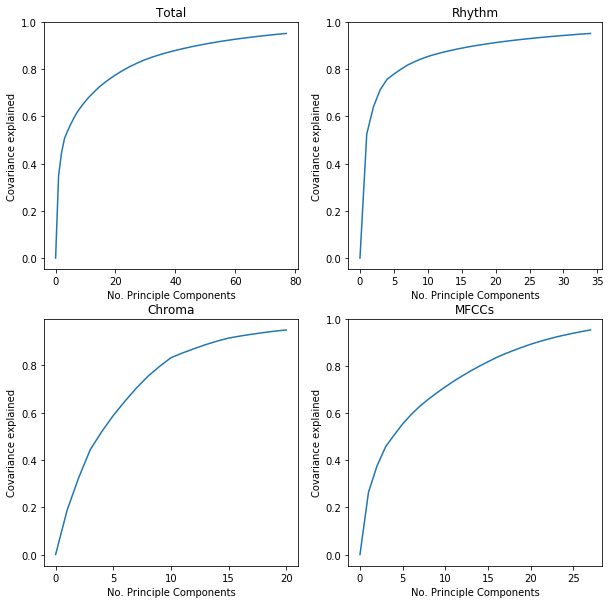

In [38]:
plt.figure(figsize=(10,10))
plt.subplot(221), plt.title('Total')
plt.plot(cov_ratios_tot)
plt.xlabel('No. Principle Components'), plt.ylabel('Covariance explained')
plt.subplot(222), plt.title('Rhythm')
plt.plot(cov_ratios_R)
plt.xlabel('No. Principle Components'), plt.ylabel('Covariance explained')
plt.subplot(223), plt.title('Chroma')
plt.plot(cov_ratios_C)
plt.xlabel('No. Principle Components'), plt.ylabel('Covariance explained')
plt.subplot(224), plt.title('MFCCs')
plt.plot(cov_ratios_M)
plt.xlabel('No. Principle Components'), plt.ylabel('Covariance explained')
plt.show()


As we also wanted to examine the effect of applying PCA to the data, we also repeated the model comparison for data that had had its dimensions reduced with PCA.

In [30]:
# PCA transformation for comparison
pca = PCA(n_components=77)
pca.fit(X_tot)
X_pca = pca.transform(X)
X_kag_pca = pca.transform(X_kag)
X_tot_pca = pca.transform(X_tot)

In [31]:
pca_splits  = train_test_split(X_pca, y, test_size=0.2, random_state=69)

tot_pca_splits = train_test_split(X_tot_pca, y_tot, test_size=0.25, random_state=42)

In [32]:
# Compare different classifiers with PCA dimension reduced data:
result_pca = compare_classifiers(classifiers, pca_splits, 
                        tot_pca_splits,
                        print_results=False, progbar=True)
display(pd.DataFrame.from_dict(result_pca, orient='index'))

IntProgress(value=0, description='Training:', max=11)

c:\users\olli\documents\02_school\mlbpa_project\py3env\lib\site-packages\sklearn\discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,accuracy,balanced accuracy,train time
AdaBoost,0.518900,0.257232,4.755986
Decision Tree,0.490263,0.225924,0.709294
Linear SVC,0.647194,0.351785,2.583850
Linear SVM,0.529210,0.454856,4.593960
Naive Bayes,0.597938,0.387299,0.024144
Nearest Neighbors,0.601375,0.270040,0.034906
Neural Net,0.568156,0.372649,33.173209
QDA,0.617411,0.294837,0.357461
RBF SVM,0.588774,0.233024,12.384875
Random Forest,0.547537,0.150961,0.317150


### 3.2 Model selection
As we can see, the neural network and did the best from the selected classifiers. With the facts that there exist multiple machine learning libraries, extensive support, and studies for implementing neural networks, we decided to implement the classifier with TensorFlow. Another fact contributing to the decision was the fact that the training could be done with GPU acceleration, thus decreasing the training time and giving more flexibility for experiments.

As the PCA seemed to have a negative effect on the performance of the neural network, we decided not to perform PCA in our classifier. We acknowledge, that there is a possibility that the performance decrease could have been caused by the single, short, training.

#### 3.2.1 Model
We implemented a deep neural network model with TensorFlow. This allowed us to quickly experiment with different setups, especially with the help of TensorBoard [2]. The final model used is shown in Figure 2.

For loss function, we used categorical cross entropy, as it scales nicely to large data and has no instability issues with large dimensionality [3]. For the optimizer, we used the TensorFlow default ADAM optimization algorithm, as is the industry standard. We tested with Stochastic Gradient Descent optimizer, but it yielded worse results. 

![](https://image.ibb.co/kv5SV0/model.png)

*Figure 2: the classification model*

Many of the iterations ended up with a overfitted model. An example can be seen in Figure 3. After reading an excellent article on how to avoid overfitting [4] we implemented dropouts and L2 loss to our network. Finally, to reduce the effect of imbalanced data, we added weights for each class to be used in loss calculation. The source code for the model can be found in Appendix A2, and the parameters used in Appendix A3.

![](https://image.ibb.co/fTzk00/run-8.png)

*Figure 3 overfitting example*

### 3.3 Experimental methods
A good data and a flexible model do not guarantee a great classifier. Especially as the data was extremely unbalanced, we decided to experiment with methods for making the classifier more accurate. This section describes the experimental methods and the results of using them.

#### 3.3.1 Data augmentation
For the unbalanced data, usually, two different approaches are suggested to augment the balanced data: oversampling and undersampling. In oversampling, we generate more data points for categories, which are underrepresented in our data set. In our case, for example, the labels 5-10. In undersampling, however, we only include a part of the samples in overrepresented categories, such as label 1 in our data.

For over- and undersampling, there exists a python library `imbalance-learn` [5], which we used to experiment. However, it offers only very limited options: oversampling methods always make all categories to contain the same amount of samples as the category with most samples in original data. In a similar fashion, undersampling methods always scale the number of samples category wise to the number of samples in the category with the least samples in the original data. These would cause, respectively, oversaturated amount of fabricated samples and great information loss due to ignored samples.

To have more flexibility and balance with information loss, we implemented a function `DataHandle.balance` which allowed us to undersample data to any given limit.

Eventually, we tested training the network with all original, oversampled and undersampled data. For oversampling, we used SMOTE [6], undersampling Random Undersampling, and balance multiple limits in range 100-1000. Any of the data-augmented trainings did not yield better results than the original. This might have implied some problem in our model, or simply lack training data.
 
 We performed the same classifier tests as for original data and PCA transformed data for the undersampled and oversampled data:

In [33]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [34]:
# ================= BALANCED DATA ==================
underSampler = NearMiss()
overSampler = SMOTE()

# --------------- UNDERSAMPLED DATA ----------------
X_us, y_us = underSampler.fit_resample(X, y)

# ---------------- OVERSAMPLED DATA ----------------
X_os, y_os = overSampler.fit_resample(X, y)

print('Original data: %d samples and %d features' % X.shape )
print('Oversampled data: %d samples and %d features' % X_os.shape )
print('Undersampled data: %d samples and %d features' % X_us.shape )

# Under- and Oversample only training data:
#  X_train, X_test, y_train, y_test
us_X, us_y = underSampler.fit_resample(orig_splits[0], orig_splits[2])
os_X, os_y = overSampler.fit_resample(orig_splits[0], orig_splits[2])
us_splits = (us_X, orig_splits[1], us_y, orig_splits[3])
os_splits = (os_X, orig_splits[1], os_y, orig_splits[3])

Original data: 4363 samples and 260 features
Oversampled data: 21780 samples and 260 features
Undersampled data: 860 samples and 260 features


In [35]:
result_us = compare_classifiers(classifiers, us_splits, 
                        data_tot_splits=tot_splits,
                        print_results=False, progbar=True)
display(pd.DataFrame.from_dict(result_us, orient='index'))

IntProgress(value=0, description='Training:', max=11)

c:\users\olli\documents\02_school\mlbpa_project\py3env\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\olli\documents\02_school\mlbpa_project\py3env\lib\site-packages\sklearn\discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,accuracy,balanced accuracy,train time
AdaBoost,0.358534,0.145150,2.734841
Decision Tree,0.146621,0.178170,0.344440
Linear SVC,0.279496,0.344104,4.611720
Linear SVM,0.308133,0.312435,0.502017
Naive Bayes,0.138603,0.197271,0.007978
Nearest Neighbors,0.381443,0.260309,0.019996
Neural Net,0.226804,0.267122,10.293509
QDA,0.132875,0.122826,0.399931
RBF SVM,0.105384,0.199034,0.815294
Random Forest,0.199313,0.182650,0.061834


In [ ]:
# Training the network and semi-supervised takes a LONG time.
# Reduce the max_iters for them to submit this notebook on time:
classifiers["Neural Net"] = MLPClassifier(alpha=0.005, learning_rate='adaptive', hidden_layer_sizes=(82,10,), max_iter=100)
classifiers["Semi-supervised"] = LabelSpreading(n_jobs=-1, max_iter=100)
result_os = compare_classifiers(classifiers, os_splits, 
                        data_tot_splits=tot_splits,
                        print_results=False, progbar=True)
display(pd.DataFrame.from_dict(result_os, orient='index'))

The tradeoff of computation time and improved accuracy was not convincing in the tests above. Moreover, as the data points were only estimated, they possibly bring noise to the process. Therefore we decided not to use oversampling in our process.

#### 3.3.2 Cross-validation
As the training data is extremely small and imbalanced, we decided to implement cross-validation to increase the efficiency of our training, and to get a more reliable evaluation of our performance. Initially, we performed K-fold cross-validation. However, as our data is imbalanced, some of the training sets had not all of the categories represented, leading to very overfitted model. Hence, we switched to Stratified Shuffle split. [7]. This allowed us to have a good representation of all the classes in each iteration. The effect of the cross-validation can be seen in Figure 4

![](https://image.ibb.co/c0Q3nf/run-3.png)

*Figure 4: Training the model with 5 cross-validation sets*

Another method, inspired by the balancing method introduced in section 3.3.1, was to rebalance the data in some iterations. This method would undersample the data iteratively, thus making all of the data eventually present for the training. Normally the undersampling is performed only once, and some of the samples are ignored. with rebalancing, the overrepresented categories would be sampled again, to include the samples which were not present in the previous iteration. However, testing this method did not improve the model and as cross-validation was more researched solution, we continued with it. moreover, in the latter state, when training the model for the kaggle estimation, we removed cross-validation after good model parameters were found.

This was implemented as an alternative to cross-validation, but in hindsight would have been more suitable to implement as data augmentation method and used alongside cross-validation.

#### 3.3.3 Semi-supervised learning
As the section two stated, we had additional, non-labeled, data available. To add the information from this to our system, we tested some semi-supervised learning. 

As seen in section 3.1, we tested the ready sklearn solution. The model was trained with a small amount of labeled data concatenated with a bunch of unlabeled data. We used the rest of labeled data as a testing data for the model. Sklearn solution model accuracy was a bit over 50% depending on the amount of given labeled data for the training. 

Additionally, we implemented a solution with pseudo labeling as described in [8]. This mechanic would assign pseudo labels for every sample in the unlabeled data, and use them to fine-tune the network. We did not see any improvement on this, as can be inspected in Figure 5.

![](https://image.ibb.co/k8H7V0/run-22.png)

*Figure 5: Semi-supervised learning with fine-tuning the trained model with assigned pseudo-labels*

Accidentally, we also implemented a third mechanic, which only applied the pseudo labels once during the training, in contrast to the relabeling after every weight update described in the paper above. Obviously, this approach leads only to overfitting problems. We tried to avoid this by only using the pseudo labels in some training steps. The results were not so good, as seen in Figure 6.

![](https://image.ibb.co/cSjk00/run-14.png)

*Figure 6: Reassigning the pseudo labels and using them randomly to train the data*

We also tried training the network from start with a dataset consisting of the given labeled data, and unlabeled data, which had been labeled with the previous best model. This approach did not improve results at all. Figure 7 shows how accuracy stayed, despite the hyperparameter tuning, at around 55%.


![](https://image.ibb.co/iKdQHf/run-20.png)

*Figure 7: Training the model again with pseudo labeled data*


Another idea we had, from using the data, was to implement an additional loss term for the training, which would utilize the unlabeled data. This loss term would be calculated from the fit of the model to the unlabeled data by summing the probabilities of each assigned label of the sample and dividing it with sample size. The motivation being that a better model would fit better even to the unlabeled data. However, due to time restrictions, this was not implemented.


### 3.4 Hyperparameter tuning
A challenge with neural networks and a limited amount of training data is the optimization of hyperparameters. These parameters include all the choices set before running the network. As the network grows and methods are added, so does the amount of hyperparameters to optimize. 

As our lack of experience in this field, most of our tuning happened of trial-and-error basis. Moreover, the lack of knowledge of the label distribution in the final evaluation data made it more difficult to optimize the model; we decided to optimize the model with the assumption that the final evaluation data would be similarly distributed as the provided training data. This mainly due to the similarity of testing and training data visible in scatter analysis in section 2.1.3.

We experimented with different amounts of hidden layers, different amounts of neurons in each layer and learning rate. As seen in the category analysis in section 2.1.4, there is no clear division of the categories. Therefore we decided to include relatively large layers and multiple of them; this to assure the model could fin the high-dimensional patterns for the classification. 

The overfit avoidance methods added some parameters: the coefficient for L2 regularisation, and dropout probabilities. Additionally, the experimental methods added the options of using them with some coefficients, such as the scale of applying loss from pseudo labeled data.
 
Moreover, out rather stochastic approach to the model tuning was not very effective. Only later in the process, we started to keep track of the changes and their effects. Implementing some hyperparameter optimizer or researching for some more systematic approach would have been more effective. 


### Class weights
As the data augmentation methods described in section 3.3.1 did not improve our performance, we applied weights for each class when calculating the loss. This, however, either made the accuracy plateau extremely fast (to around accuracy 50%), or did not affect the label assigning after some iterations, as seen in Figure 8. The weights used in the final model can be found in Table 3.


![](https://image.ibb.co/ncwZA0/class-weight-effect.png =300x)

*Figure 8: Label predictions (above) and real labels (below) over iterations*

#### 3.5 Used model

After the meticulous tuning, we ended up with the model described in table 2.

*Table 2: Model hyperparameters:*

Parameter | Value
------------|-------
No. hidden layers | 2
Layer 1 dropout | 0.9
Layer 2 dropout | 0.7
Iterations| 10000
CV Shuffles | 2
Learning rate alpha | 0.0001
L2 regulation: beta | 0.002

*Table 3: Class weights used in calculating the cross-entropy*

Class | Weight
---|---
1|0.5
2|0.7
3|0.8
4|0.9
5|1
6|1
7|1
8|1
9|1
10|1

The development of training and testing accuracy from the training of said model can be seen in Figure 9.

![](https://image.ibb.co/fCEDnf/best-run.png)

*Figure 9: Final model training. Orange and cyan are training sets for first and second cross-validation set respectively. Blue and red lines are the evaluation accuracy for first and second cross-validation set respectively*

The training of the final model took around 23 minutes.

## 4. Results

After finding the best model we trained it once more with no splitting into train and testing set. This was to include as much information to it as possible. We then evaluated the samples and obtained the predictions.

The following cells calculate the performance measures and confusion matrix for the provided training data. 

In [39]:
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score

In [42]:
#Confusion matrix:
real_labels = dataHandle.load_clean_train_data().Label + 1
predicted_labels = pd.DataFrame.from_csv('predicted_labels_train.csv').sample_label
display(pd.DataFrame(confusion_matrix(real_labels, predicted_labels)))

# Accuracy:
print('Accuracy:', accuracy_score(real_labels, predicted_labels))

#LogLoss:
predicted_probas = pd.DataFrame.from_csv('predicted_log_loss_train.csv')
print('LogLoss:', 1-log_loss(real_labels, predicted_probas))

c:\users\olli\documents\02_school\mlbpa_project\py3env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2,3,4,5,6,7,8,9
0,1905,112,22,27,21,61,1,29,0,0
1,108,455,21,13,8,11,0,1,1,0
2,20,24,261,2,2,14,0,3,0,0
3,35,14,2,179,1,21,0,1,0,0
4,76,10,6,12,83,16,0,7,4,0
5,45,6,14,13,8,162,0,12,0,0
6,52,16,6,16,24,8,0,15,4,0
7,79,1,1,4,4,2,0,104,0,0
8,5,6,29,2,11,15,0,3,21,0
9,38,1,4,15,6,3,0,18,0,1


Accuracy: 0.7267934907173963
LogLoss: 0.10490520263388436


c:\users\olli\documents\02_school\mlbpa_project\py3env\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # Remove the CWD from sys.path while we load stuff.


The corresponding measures from the last Kaggle submission were:

Accuracy: 0.64544  
LogLoss: 0.17204

In other words slightly worse than those obtained by evaluating only the training data. This was expected, as the data in Kaggle has data unseen by our model. however, the overall  performance was, within limits, relatively similar in both cases. It is also good to acknowledge, that in the score gotten from Kaggle was obtained by evaluating only 30% of the available data, therefore adding the possibility of the score alternating slightly if all of the data was considered.


## 5. Discussion

Despite our numerous efforts in classifier selection and model tuning, we did not achieve impressive results. Compared to the Kaggle leaderboard at the time of the submission, we did average at best, telling that we have overlooked something. However, compared to a song genre classification model presented in [9], the accuracy was satisfactory. Nevertheless, the problem of implementing a reliable classifier for such imbalanced data, and with limited training data is relatively difficult. Moreover, assigning music genre to a song is an ambiguous task, as stated in the problem description: *"For simplicity, each song has been assigned only one label that corresponds to the most representative genre."* This can be more analyzed by examining the confusion matrix in section 4.

The classifier has obviously tried to maximize the accuracy by labeling songs strongly to the pop-rock genre, even despite the class weights. We can see that the genres close to each other, style-wise, have the most confusion within them, such as blues and rock. Additionally, the amount of training samples correlates with the precision. As for the performance measures, the LogLoss is much better for the imbalanced, multiclass data: it allows us to calculate the performance based on all of the classes and not the dominating one. Accuracy can be affected by it much more and give a distortedly good performance. In hindsight, we should have trained the model one more time with extreme weights on other than the first class to improve the result of LogLoss.

We believe that we concentrated too harshly on finetuning the one selected model, whereas we should have researched more options for both preprocessing and modelling. Therefore we can assume improvement for the model only by trying different methods, which would require more time. Especially one differing technique we did not try was to implement a set of one-versus-rest classifiers and combining them. That might have been useful with such inbalanced data, as it might have given more control for the weighing of the class assignment probabilities and prevent overfitting to one dominating class. 

However, as the case is with most classification problems, the most probable way of improving the model would be to gather more data. Due to the nature of the project, this was not possible, but certainly would be interesting to test training the model with the true labels of the unlabeled dataset as well.

The results of the project were of mixed feelings: we believed that at least some of the experimental methods described in section 3.3 would had affected the performance positivley. Unfortunately this was not the case. On one hand this shows the power of a simple deep neural network, but on the other hand it opens the discussion of the reliability and correctedness of our model. Nevertheless, we are satisfied with the experience and vast amount of possibillities covered by these experiments. 

## 6. References

In [0]:
[1] Scikit-learn. [Website] Available: http://scikit-learn.org/stable/supervised_learning.html#supervised-learning.
    [Accessed: 2.11.2018].
    
[2] TensorFlow. [Website] Available: https://www.tensorflow.org/guide/summaries_and_tensorboard.
    [Accessed: 2.11.2018].
    
[3] Ml-cheatsheet. [Website] Available: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
    [Accessed: 2.11.2018]

[4] CS231n. [Website] Available: http://cs231n.github.io/neural-networks-3/#sanitycheck
    [Accessed: 2.11.2018]

[5] Imbalanced-learn. [Website] Available: https://imbalanced-learn.readthedocs.io/en/stable/
    [Accessed: 2.11.2018].
    
[6] Nitesh V. Chawla et al. (2002) SMOTE: Synthetic Minority Over-sampling Technique. [Website] Available: https://jair.org/index.php/jair/article/view/10302/24590
    [Accessed: 2.11.2018]
  
[7] Z. Reitermanová. (2010) Data Splitting. [Article] Available: https://www.mff.cuni.cz/veda/konference/wds/proc/pdf10/WDS10_105_i1_Reitermanova.pdf
    [Accessed: 2.11.2018]

[8] Dong-Hyun Lee. Pseudo-Label : The Simple and Efficient Semi-Supervised Learning Method for Deep Neural Networks. [Article] Available: http://deeplearning.net/wp-content/uploads/2013/03/pseudo_label_final.pdf
    [Accessed: 2.11.2018]
    
[9] Piotr Kozakowski & Bartosz Michalak. (2016) Music Genre Recognition. [Website] Available: http://deepsound.io/music_genre_recognition.html
    [Accessed: 2.11.2018]

## Appendix


### A1 Source code for DataHandle

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as spre
import os
from collections import Counter
import matplotlib.pyplot as plt
import warnings

class DataHandle:
    def __init__(self):
        """ A Handle for loading the data

            The data is not uniform. This class helps to
            load and save, if needed, the data of project.
        """
        # Data paths:
        self.__DIR = '.'  # os.path.dirname(os.path.realpath(__file__))  # (FIX for jupyter)
        self.__DATA_PATH = self.__DIR+'/data/'
        # Provided data:
        self.train_data_file = self.__DATA_PATH+'train_data.csv'
        self.valid_data_file = self.__DATA_PATH+'test_data.csv'
        self.train_label_file = self.__DATA_PATH+'train_labels.csv'
        # Generated data:
        self.feature_label_file = self.__DATA_PATH+'feature_labels.csv'
        # Cleaned data:
        self.clean_train_file = self.__DATA_PATH+'clean_train.csv'
        self.clean_test_file = self.__DATA_PATH+'clean_test.csv'

        # Statistics aggregated from sampled data:
        self.R_types = ['mean', 'median', 'var', 'kurt', 'skew', 'min', 'max']
        self.C_types = ['mean', 'std', 'min', 'max']
        self.M_types = ['mean', 'std', 'min', 'max']

        # Sampling variables:
        self.R_bands = 24
        self.C_pitches = 12
        self.M_coefs = 12

        # Category labels:
        self.category_labels = [
            '1. Pop_Rock', 
            '2. Electronic', 
            '3. Rap',
            '4. Jazz', 
            '5. Latin', 
            '6. RnB',
            '7. International', 
            '8. Country', 
            '9. Reggae', 
            '10. Blues',
        ]

        self.data = None
        # Colours for fun!
        # https://xkcd.com/color/rgb/
        self.category_colours = ['xkcd:'+c for c in [
            'burnt umber',
            'acid green',
            'grape',
            'watermelon',
            'lipstick red',
            'bluegrey',
            'dust',
            'golden yellow',
            'jungle green',
            'midnight blue',
        ]]

        # GEnerate feature labels for easy indexing 
        self.create_feature_labels()

        # Generate dict-lists for feature type labels
        self.R_type_labels = {
            t: [f'R_{t}_{i}' for i in range(self.R_bands)] for t in self.R_types
        }
        self.C_type_labels = {
            t: [f'C_{t}_{i}' for i in range(self.C_pitches)] for t in self.C_types
        }
        self.M_type_labels = {
            t: [f'M_{t}_{i}' for i in range(self.M_coefs)] for t in self.M_types
        }

    def labels_for(self, stat, t):
        """ Return the set of labels for certain statistic and type

            Arguments:
                stat (str):, either 'R', 'C' or 'M' to select statistic
                t (str): a tag to select type

            Return (list):
                A list of the tags assigned for this statistic type
        """
        if stat == 'R':
            l = [f'R_{t}_{i}' for i in range(self.R_bands)]
        elif stat == 'C':
            l = [f'C_{t}_{i}' for i in range(self.C_pitches)]
        elif stat == 'M':
            l = [f'M_{t}_{i}' for i in range(4, self.M_coefs)]
        else:
            raise ValueError('not recognised stat')
        return l

    def load_train_data_to_memory(self, 
                                  labels=False, normalise_labels_to=(0,9),
                                  feature_labels=False, remove_features=[]):
        """ open the data to memory

            Allows data feed with load functions later
        """
        self.data = pd.read_csv(self.train_data_file, header=None, sep=',')
        
        # Add feature labels if needed:
        if feature_labels:
            f_labels = self.load_feature_labels()
            self.data.columns = f_labels

        if remove_features:
            self.data.drop(remove_features, axis=1, inplace=True)

        # Add labels if needed:
        if labels:
            labels = self.load_labels(normalise_labels_to)
            self.data['Label'] = labels
    
    def data_generator(self, data, n_yields, 
                       balance_lim='max', rand_seed_start=None,
                       as_tuple=False):
        """ Create a generator for random sampling of the data

            Expect the data has 'Label' column.

            Arguments:
                balance_lim (int,str): if int, describes the limit
                    if str, can be 'min'or 'max'
                as_tuple (bool): Return tuple with (X, y) dataFrames
            Yield:
                A dataframe of data
        """

        # Count the number of different labels in the data:
        cntr = Counter(list(data.Label))

        if balance_lim == 'max':
            # A bit redundant but nice implementation
            lim = cntr.most_common()[0][1]
        elif balance_lim == 'min':
            # Limit to minimum amount of elmeents in category:
            lim = cntr.most_common()[-1][1]
        elif isinstance(balance_lim, int):
            lim = balance_lim
        elif isinstance(balance_lim, float):
            raise NotImplementedError('float division lims')
        else:
            raise ValueError('Invalid balance_lim argument') 

        for y in range(n_yields):
            if rand_seed_start is not None: 
                seed = rand_seed_start + y
            else:
                seed = None
            # Init the filtered DataFrame:
            yielded_df = pd.DataFrame()

            # Sample each category to lim:
            for lbl, cnt in iter(cntr.items()):
                sample = data[data.Label == lbl].sample(n=min(lim, cnt), 
                    random_state=seed)
                yielded_df = pd.concat([yielded_df, sample], 
                    axis=0, ignore_index=True)

            if as_tuple:
                yield ( yielded_df.drop(['Label'], axis=1), yielded_df['Label'])
            else:
                yield yielded_df

    def clean_data(self):
        """ Cleans the training and testing data and saves clean files.

            Following steps are made:
                1. Load train and test data
                2. Label features
                3. Remove features which are anomalies
                4. Normalise features based on statistic
                    - Remove outliers by capping
                    - Normalise to 0-1
                5. Save the data to:
                    - clean_train.csv
                    - clean_test.csv
        """
        # 1. Load train and test data
        d_train = self.load_train_data(
            labels=True, feature_labels=True,
            normalise=False, balanced=False)
        d_test = self.load_test_data(
            labels=True, feature_labels=True, 
            normalise=False)
        data = pd.concat([d_train, d_test])

        # 3. Remove features which are anomalies (based on analysis notebook)
        data.drop(['M_mean_0', 'M_mean_1', 'M_mean_2', 'M_mean_3'], 
            axis=1, inplace=True)

        # 4. Normalise features based on statistic
        #    - Remove outliers by capping
        # based on analysis notebook:

        caps = {
            'R': {
                'mean': (1, 14500),
                'median': (0, 30000),
                'kurt': (1000, 500000),
                'skew': (1, 15000),
                'min': (1, 8000),
                'max': (1, 31500),
                'var': (-2000, 20000)
            },
            'C': {
                'mean': (0, 1),
                'std': (0, 1),
                'min': (0, 0.6),
                'max': (0, 1),
            },
            'M': {
                'mean': (-1, 1),
                'std': (0, 6),
                'min': (-1, 1),
                'max': (-1, 1),
            }
        }
        # Rhythm:
        for stat, cols in self.R_type_labels.items():
            for col in cols:
                data[col] = data[col].clip(*caps['R'][stat])
        for stat, cols in self.C_type_labels.items():
            for col in cols:
                data[col] = data[col].clip(*caps['C'][stat])
        for stat, cols in self.M_type_labels.items():
            for col in cols:
                # HACK:
                if col in ['M_mean_0', 'M_mean_1', 'M_mean_2', 'M_mean_3']:
                    continue
                data[col] = data[col].clip(*caps['M'][stat])

        # Normalise to 0-1
        labels = data['Label']
        df = data.drop('Label', axis=1)
        min_max_scaler = spre.MinMaxScaler()
        scaled = min_max_scaler.fit_transform(df.values)
        data = pd.DataFrame(scaled, columns=df.columns)
        data['Label'] = labels.values
    
        # 5. Save the data to:
        train_data = data[data.Label != -1]
        test_data = data[data.Label == -1]
        train_data.to_csv(self.clean_train_file, index=False)
        test_data.to_csv(self.clean_test_file, index=False)

    def load_clean_train_data(self):
        """ Loads cleaned training data from a file

            Return (DataFrame)
        """
        data = pd.read_csv(self.clean_train_file, header=0)
        return data
        #raise NotImplementedError()
    
    def load_clean_test_data(self):
        """ Loads cleaned testing data from a file

            Return (DataFrame)
        """
        data = pd.read_csv(self.clean_test_file, header=0)
        return data
        #raise NotImplementedError()

    def to_accuracy_kaggle_format_csv(self, labels, suppress=False):
        """ Save the labels into a csv format suitable for Kaggle

            For the accuracy competition.

            Arguments:
                labels (list-like): list of predicted labels

            syntax: 
                row: Id, predicted_label
        """
        # TODO: Implement better
        if not isinstance(labels, list):
            if isinstance(labels, np.ndarray):
                if labels.shape != (1, 6544, 10):
                    print(labels.shape)
                    raise ValueError('Invalid shape! (1, 6544, 10)')
                labels = labels.squeeze()
                labels = list(np.argmax(labels, axis=1)+1)
                print("NOTE:", len(labels), min(labels), max(labels))
                suppress = True
            else:
                raise TypeError('please provide a list or numpy array')
        if not suppress:
            if np.min(labels) != 1:
                print('min, max',np.min(labels), np.max(labels), len(labels), suppress)
                raise ValueError('Labels not in range (1, 10) (min != 1)')
            if np.max(labels) != 10:
                raise ValueError('Labels not in range (1, 10) (max != 10)')
        
        df = pd.DataFrame({'sample_label':labels})
        df.index += 1
        
        with open('kaggle_acc_ps.csv', 'w') as f:
            df.to_csv(f, index=True, columns=None, index_label='sample_id')
            print('SAVED!')
        # raise NotImplementedError()

    def to_logloss_kaggle_format_csv(self, labels):
        """ Save the labels into a csv format suitable for Kaggle

            For the multiclass log-loss competition.

            Arguments:
                labels (numpy array): and array of label probabilities

            syntax: 
                row: Id, prob_for_label_1, ... ,prob_for_label_10 
        """
        print('saving logloss, shape:', labels.shape)
        # Create columns:
        cols = [f'Class_{i}' for i in range(1,11)]
        # Convert from log-prob to prob
        d = np.exp(labels.squeeze())
        # COnvert to dataframe for easy export
        df = pd.DataFrame(d, columns=cols)
        df.index += 1
        with open('kaggle_log_loss_ps.csv', 'w') as f:
            df.to_csv(f, index=True, columns=None, index_label='sample_id')
            print('SAVED!')
        #raise NotImplementedError()

    def load_train_data(self, labels=False, normalise_labels_to=(0,9),
                        feature_labels=False,
                        normalise=True, balanced=False, balance_lim='min',
                        uniform=None, unifrom_rand_seed=None,
                        as_tuple=False):
        """ Loads available training data.

            As data is skewed, some balanced selection is needed.
            If set, function samples data so each category is 
            represented in equal amounts.

            Note that the labels are added to the DataFrame if 
            balanced is True.

            Arguments:
                labels (bool): Whether to append data with label vector
                clean (bool): Load cleaned data
                normalise_labels_to (tuple): make labels fit into the range
                normalise (bool): Normalise variables to 0-1
                feature_labels (bool): Append feature names as columns
                balanced (bool): Sample data so it is balanced
                balance_lim (int): Limit for balancing classes.
                as_tuple (bool): Whether to return tuple, (X, y)
            
            Return (pandas.DataFrame):
                A pandas DataFrame with training data. 
            
            The rows and columns of the returned DataFrame are the 
            observations and features of the training data respectively.

            If the balance_lim is not set, the values are selected to have
            the same number of values form each class, so that the class
            with least values in original distribution includes them all.
        """
        # Load data from file:
        if self.data is None:
            data = pd.read_csv(self.train_data_file, header=None, sep=',')
        else:
            data = self.data
        
        # Normalise variables:
        # TODO: Fix
        if normalise:
            x = data.values
            min_max_scaler = spre.MinMaxScaler()
            x_scaled = min_max_scaler.fit_transform(x)
            data = pd.DataFrame(x_scaled)

        # Add feature labels if needed:
        if feature_labels:
            f_labels = self.load_feature_labels()
            data.columns = f_labels

        # Add labels if needed:
        if labels:
            labels = self.load_labels(normalise_labels_to)
            data['Label'] = labels
        
        # Check for legacy mode:
        if uniform is not None:
            warnings.warn(
                '"uniform" kwarg is deprecated. Use "balanced" instead ',
                FutureWarning)
            balanced = uniform

        # Select a uniform representation if needed:
        if balanced:
            data = self.balance_data(data, 
                balance_lim=balance_lim,
                seed=unifrom_rand_seed)
            """ OLD
            if 'Label' not in data:
                labels = self.load_labels(normalise_labels_to)
                data['Label'] = labels
            cntr = Counter(list(labels))
            # Limit to minimum amount of elmeents in category:
            if balance_lim == 'max':
                # A bit redundant but nice implementation
                lim = cntr.most_common()[0][1]
            elif balance_lim == 'min':
                # Limit to minimum amount of elmeents in category:
                lim = cntr.most_common()[-1][1]
            elif isinstance(balance_lim, int):
                lim = balance_lim
            elif isinstance(balance_lim, float):
                raise NotImplementedError('float division lims')
            else:
                raise ValueError('Invalid balance_lim argument') 

            
            # Init the filtered DataFrame:
            balanced_df = pd.DataFrame()

            # Sample each category to lim:
            for lbl, cnt in iter(cntr.items()):
                sample = data[data.Label == lbl].sample(n=min(lim, cnt), 
                    random_state=unifrom_rand_seed)
                balanced_df = pd.concat([balanced_df, sample], 
                    axis=0, ignore_index=True)

            data = balanced_df
            """
        return data

    def load_test_data(self, labels=False, feature_labels=False,
                       normalise=True):
        """ Loads available test data.

            As data is skewed, some balanced selection is needed.
            If set, function samples data so each category is 
            represented in equal amounts.

            Note that the labels are added to the DataFrame if 
            balanced is True.

            Arguments:
                labels (bool): Whether to append data with label vector (-1s)
                normalise (bool): Normalise variables to 0-1
                feature_labels (bool): Append feature names as column names
            
            Return (pandas.DataFrame):
                A pandas DataFrame with training data. 
            
            The eows and columns of the returned DataFrame are the 
            observations and features of the training data respectively.

            NOTE: Consider whether to sample all available data when 
            normalising the data.
        """
        # Load data from file:
        data = pd.read_csv(self.valid_data_file, header=None, sep=',')
        
        # Normalise variables:
        if normalise:
            x = data.values
            min_max_scaler = spre.MinMaxScaler()
            x_scaled = min_max_scaler.fit_transform(x)
            data = pd.DataFrame(x_scaled)

        # Add feature labels if needed:
        if feature_labels:
            f_labels = self.load_feature_labels()
            data.columns = f_labels

        # Add labels if needed. Augment as -1 as labels are not known:
        if labels:
            labels = -1*np.ones(data.shape[0])
            print(labels.shape, data.shape)
            data['Label'] = labels

        return data 

    def balance_data(self, data, balance_lim='min', seed=None):
        
        cntr = Counter(list(data.Label.values))
        # Limit to minimum amount of elmeents in category:
        if balance_lim == 'max':
            # A bit redundant but nice implementation
            lim = cntr.most_common()[0][1]
        elif balance_lim == 'min':
            # Limit to minimum amount of elmeents in category:
            lim = cntr.most_common()[-1][1]
        elif isinstance(balance_lim, int):
            lim = balance_lim
        elif isinstance(balance_lim, float):
            raise NotImplementedError('float division lims')
        else:
            raise ValueError('Invalid balance_lim argument') 

        # Init the filtered DataFrame:
        balanced_df = pd.DataFrame()

        # Sample each category to lim:
        for lbl, cnt in iter(cntr.items()):
            sample = data[data.Label == lbl].sample(n=min(lim, cnt), 
                random_state=seed)
            balanced_df = pd.concat([balanced_df, sample], 
                axis=0, ignore_index=True)

        return balanced_df

    @staticmethod
    def check_label_space(labels, space):
        """ Check if the labels are in defined space, e.g. 0-9

            Arguments:
            labels (list like):  labels to check
                space (tuple): range for the space, e.g. (1,10)
            
            Return (bool):
                Whether all labels are within the range 
        """
        print((*(space[0], space[1]+1)))
        return all(l in range(*(space[0], space[1]+1)) for l in labels)

    def load_labels(self, normalise_to=(0,9)):
        """ Load category labels

            Return (list):
                List of the labels

            TODO: horrible implementation, redo!
        """
        lbls = pd.read_csv(self.train_label_file,
            header=None,sep=',').values.flatten()

        if normalise_to == (0,9):
            lbls += -1
        if self.check_label_space(lbls, normalise_to):
            return  lbls
        else:
            raise ValueError('Invalid label space provided or not matched!')

    def load_feature_labels(self):
        """ Load feture labels

            Return (list):
            List of labels
        """
        return pd.read_csv(self.feature_label_file, 
            header=None, sep='\n').values.flatten()

    def create_feature_labels(self):
        """ A simple script to form feature labels

            Currently features are recognised only by their
            index reate a file with labels, separating the
            rhythm, chroma and MFCCs.

            Therefore, the labels shall be the following:
            Column(s) | Feature type | Feature label(s)
            ----------|--------------|-----------------
                    0 | ID           | ID
                1-168 | Rhythm       | R0-R167
              169-217 | Chroma       | C0-C47
              218-264 | MFCCs        | M0-M47
        """
        self.labels_R = ['R_'+t+'_'+str(i) for t in self.R_types 
            for i in range(self.R_bands)]
        self.labels_C = ['C_'+t+'_'+str(i) for t in self.C_types
            for i in range(self.C_pitches)]
        self.labels_M = ['M_'+t+'_'+str(i) for t in self.M_types 
            for i in range(self.M_coefs)]

        return self.labels_R+self.labels_C+self.labels_M

    def save_feature_labels(self):
        """ Save the created category labels
        """
        labels = self.create_feature_labels()
        print(f'Created label vector of length: {len(labels)}')

        # Save as csv:
        with open('data/feature_labels.csv', 'w') as f:
            f.write('\n'.join(labels))

        print('Saved the labels')


### A2 source code for the model

In [0]:
""" A full implementation of the tensorflow classificator

    Decided to move here as it takes quite a bit of space 
    in the notebook. Also, here the code factoring is a 
    bit nicer.

    NOTE: Edited from:
    https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/mnist_with_summaries.py

    TODO: Add to the notebook if used in th final version.
"""

from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
import pandas as pd

import FLAGS
import data_handle as dh

def train(train_x_all, train_y_all, test_x, test_y, unlbl_X=None, pseudo_y=None):
    # ============================= SESSION INIT ==============================
    sess = tf.InteractiveSession()

     # ========================== HELPER FUNCTIONS ============================
    # Declare some helper funcitons for the tensorboard inspection:
    def variable_summaries(var):
        """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

    # We can't initialize these variables to 0 - the network will get stuck.
    def weight_variable(shape):
        """Create a weight variable with appropriate initialization."""
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        """Create a bias variable with appropriate initialization."""
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu, U=None):
        """Reusable code for making a simple neural net layer.
        It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
        It also sets up name scoping so that the resultant graph is easy to read,
        and adds a number of summary ops.
        """
        with tf.name_scope(layer_name):
            with tf.name_scope('weights'):
                weights = weight_variable([input_dim, output_dim])
                variable_summaries(weights)
            with tf.name_scope('biases'):
                biases = bias_variable([output_dim])
                variable_summaries(biases)
            with tf.name_scope('Wx_plus_b'):
                preactivate = tf.matmul(input_tensor, weights) + biases
                tf.summary.histogram('pre-activations', preactivate)
                if U is not None:
                    pre_U = tf.matmul(input_tensor, weights) + biases
            activations = act(preactivate, name='activation')
            regularisations = tf.nn.l2_loss(weights)
            tf.summary.histogram('activations', activations)
            tf.summary.histogram('regularisations', regularisations)
            act_U = None if U is None else act(pre_U, name='activation_U')
            return activations, regularisations, act_U


    # ============================ NETWORK SETUP =============================
    # Inputs:
    with tf.name_scope('input'):
        # Feature matrix:
        x  = tf.placeholder(tf.float32, [None, FLAGS.n_features], name='x-input')
        # Labels:
        y_ = tf.placeholder(tf.int64, [None], name='y-input')
        keep_prob1 = tf.placeholder(tf.float32)
        keep_prob2 = tf.placeholder(tf.float32)
        keep_prob3 = tf.placeholder(tf.float32)

        if FLAGS.class_weights is not None:
            class_weights = tf.placeholder(tf.float32, [None], name='class_weights')
        if FLAGS.unlabeled_loss:
            U_x = tf.placeholder(tf.float32, [None, FLAGS.n_features], name='x-input')
        else:
            U_x = None
    # Layer(s):
    # -------------------------------  LAYER 1 --------------------------------
    hidden, reg1, Uh = nn_layer(x, FLAGS.n_features, FLAGS.n_nodes_layer1, 
                             'layer1', act=FLAGS.act1, U=U_x)
    prev_out_shape =  FLAGS.n_nodes_layer1
    regs = reg1
    with tf.name_scope('dropout1'):
        tf.summary.scalar('dropout_keep_probability',keep_prob1)
        dropped = tf.nn.dropout(hidden, keep_prob1)
    
    # -------------------------------  LAYER 2 --------------------------------
    if FLAGS.use_layer_2:
        hidden, reg2, Uh = nn_layer(dropped, prev_out_shape, FLAGS.n_nodes_layer2,
                                'layer2',  act=FLAGS.act2, U=Uh)
        prev_out_shape =  FLAGS.n_nodes_layer2
        regs += reg2
        with tf.name_scope('dropout2'):
            tf.summary.scalar('dropout_keep_probability',keep_prob2)
            dropped = tf.nn.dropout(hidden, keep_prob2)

    # -------------------------------  LAYER 3 --------------------------------
    if FLAGS.use_layer_3:
        hidden, reg3, Uh = nn_layer(dropped, prev_out_shape, FLAGS.n_nodes_layer3,
                                'layer3',  act=FLAGS.act3, U=Uh)
        prev_out_shape =  FLAGS.n_nodes_layer3
        regs += reg3
        with tf.name_scope('dropout3'):
            tf.summary.scalar('dropout_keep_probability',keep_prob3)
            dropped = tf.nn.dropout(hidden, keep_prob3)

    # -------------------------------  LAYER Y --------------------------------
    # Do not apply softmax activation yet, see below.
    y, reg_y, Uh = nn_layer(dropped, prev_out_shape, FLAGS.n_labels,
                'layer_out', act=tf.identity, U=Uh)
    regs += reg_y


    # -------------------------------  UPDATE --------------------------------
    
    with tf.name_scope('cross_entropy'):
        with tf.name_scope('bare'):
            # Apparently there is some instability issues with sparse_*
            # Use one-hot instead:
            y_ce = tf.one_hot(y_, FLAGS.n_labels)
            loss = tf.losses.softmax_cross_entropy(y_ce, y, weights=class_weights)
            tf.summary.scalar('cross_entropy', loss)
        with tf.name_scope('with_L2_reg'):
            loss = loss + FLAGS.beta * (regs)
            tf.summary.scalar('cross_entropy_l2', loss)
        with tf.name_scope('with_pseudo_loss'):
            # Propagate the unlabaleled data through the network.
            # calculate the log-probs.
            if FLAGS.unlabeled_loss:
                pseudo_loss = FLAGS.jotta * tf.reduce_sum(tf.nn.softmax(Uh))
                input(pseudo_loss.shape)
                loss = loss + pseudo_loss

        
    # ------------------------------- OPTIMISER -------------------------------
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(FLAGS.alpha).minimize(loss)
        #train_step = tf.train.GradientDescentOptimizer(FLAGS.alpha).minimize(loss)
    # --------------------------------- STATS --------------------------------
    with tf.name_scope('predictions'):
        predictions = tf.argmax(y, 1)
        log_probs = tf.log(tf.nn.softmax(y))
        tf.summary.histogram('log_probabilities', log_probs)

    with tf.name_scope('Classifier_performance'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(predictions, y_)
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

        with tf.name_scope('label_contingency'):
            tf.summary.histogram('Real labels', y_)
            tf.summary.histogram('Predicted labels', predictions)

    # Merge all the summaries for writing
    merged = tf.summary.merge_all()


    # ============================ TRAINING SETUP =============================
    def iterative_train(train_x, train_y, val_x, val_y,
                        train_writer, test_writer, glob_step,
                        unlbl_X=None, pseudo_y=None):
        def feed(train):
            if train:
                if (unlbl_X is not None and 
                    pseudo_y is not None and 
                    np.random.rand(1)[0] < FLAGS.kappa):

                    full_X = np.vstack((train_x, unlbl_X))
                    full_y = np.hstack((train_y, pseudo_y))
                    u_w =  [FLAGS.gamma * FLAGS.class_weights[int(i)] for i in pseudo_y] 
                    full_w =  [FLAGS.class_weights[int(i)] for i in train_y] + u_w
                    # print('Using pseudo!')
                    return  {
                        x: full_X,
                        y_: full_y,
                        keep_prob1: FLAGS.dropout1,
                        keep_prob2: FLAGS.dropout2,
                        keep_prob3: FLAGS.dropout3,
                        class_weights: full_w,
                    } 
                return  {
                        x: train_x,
                        y_: train_y,
                        keep_prob1: FLAGS.dropout1,
                        keep_prob2: FLAGS.dropout2,
                        keep_prob3: FLAGS.dropout3,
                        class_weights: [FLAGS.class_weights[int(i)] for i in train_y]
                } 
            else:
                return {
                        x: test_x,
                        y_: test_y,
                        keep_prob1: 1,
                        keep_prob2: 1,
                        keep_prob3: 1,
                        class_weights: [FLAGS.class_weights[int(i)] for i in test_y]
                } 
        # Iterate over steps
        for i in range(FLAGS.max_steps):
            if i % 10 == 0:  # Record summaries and test-set accuracy
                summary, acc = sess.run([merged, accuracy],
                    feed_dict=feed(train=False))
                test_writer.add_summary(summary, glob_step)
                
                if i % 100 == 0:
                    print('Accuracy at step %s: %s' % (i, acc))

            else:  # Record train set summaries, and train
                if i % 100 == 99:  # Record execution stats
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                    run_metadata = tf.RunMetadata()
                    summary, _ = sess.run([merged, train_step],
                                            feed_dict=feed(train=True),
                                            options=run_options,
                                            run_metadata=run_metadata)
                    train_writer.add_run_metadata(run_metadata, 'step%03d' % glob_step)
                    train_writer.add_summary(summary, glob_step)
                    print('Adding run metadata for', glob_step)

                else:  # Record a summary
                    summary, _ = sess.run([merged, train_step], 
                        feed_dict=feed(train=True))
                    train_writer.add_summary(summary, glob_step)
            if FLAGS.semi_supervised and i and ((i % FLAGS.ss_relabel == 0) or \
                (FLAGS.continuous_update and i > FLAGS.ss_relabel)):
                # Assign pseudo labels for the unlabeled data:
                pseudo_y = sess.run(predictions, feed_dict={
                    x: unlbl_X,
                    keep_prob1: 1,
                    keep_prob2: 1,
                    keep_prob3: 1,
                })
                with tf.name_scope('pseudo_labeling'):
                    tf.summary.histogram('pseudo_y', pseudo_y)
            glob_step += 1
        return glob_step

    # -------------------------- CROSS VALIDATION -----------------------------
    def cross_validate(train_x_all, train_y_all, test_x, test_y,
                       unlbl_X=None, pseudo_y=None):
        import matplotlib.pyplot as plt
        """ Perform  Stratified Kfold Shuffle to augment data

            Meant to battle overfitting
        """
        results = []
        glob_step = 0

        # Prepare the shuffler:
        shfl = StratifiedShuffleSplit(n_splits=FLAGS.split_size)
        print(f'total number of training x samples:{train_x_all.shape}')
        print(f'total number of training y samples:{train_y_all.shape}')
    
        # (DEPRECATED) Tensorflow requires labels as one-hot.
        # Convert our multiclass labels into a one-hot arrays:
        #train_y_all = (np.arange(11) == train_y_all[:,None]).astype(np.float32)
        #test_y = (np.arange(11) == test_y[:,None]).astype(np.float32)
        
        # Iterate over shuffles:
        for f, (train_idx, val_idx) in enumerate(shfl.split(train_x_all, train_y_all)):
            # Initiate writers for summaries:
            train_writer = tf.summary.FileWriter(
                f'{FLAGS.train_summary_path}/fold{f}/',sess.graph, flush_secs=60)
            test_writer = tf.summary.FileWriter(
                f'{FLAGS.test_summary_path}/fold{f}/', flush_secs=60)
        
            # Set the data for this fold:
            train_x = train_x_all[train_idx]
            train_y = train_y_all[train_idx]
            val_x = train_x_all[val_idx]
            val_y = train_y_all[val_idx]
            # Show some curves:
            if FLAGS.plot_label_dists:
                print(f'Shfl {f}, shape X: {train_x.shape}, y shape: {val_y.shape}')
                plt.figure()
                plt.subplot(121), plt.hist(train_y), plt.title('Train labels')
                plt.subplot(122), plt.hist(val_y), plt.title('Test labels')
                plt.suptitle(f'Shfl {f}, shape X: {train_x.shape}, y shape: {val_y.shape}')
                plt.show()
            # Update global step for folds/ shuffles:
            glob_step = iterative_train(train_x, train_y, val_x, val_y,
                        train_writer, test_writer, glob_step,
                        unlbl_X, pseudo_y)

            # Evaluate performance with test data

            eval_acc = sess.run(accuracy, feed_dict={
                x: test_x, 
                y_: test_y, 
                keep_prob1:1,
                keep_prob2:1,
                keep_prob3:1,})
            results.append(eval_acc)

            print(results)
            train_writer.close()
            test_writer.close()
    
        print(results)
    
    # ----------------------------- RESAMPLING --------------------------------
    def rebalancing_train(train_data, test_x, test_y):
        """ Modified data resampling

            Loop over the trian data. loading a balanced dataset each time
            Each iteration has sampled the data with different random seed
            Thus the labels are still equally represented but no information
            is lost.

            Highly experimental and slow in terms of loading data; this due
            the chewy implementation of data loading. Should be a generator.
        """
        results = []
        glob_step = 0
        # Init data generator
        dataHandle = dh.DataHandle()
        # Produces data resampled as (X, y)
        data_gen = dataHandle.data_generator(
            train_data, 
            n_yields=FLAGS.rebalance_lim,
            balance_lim=FLAGS.balance_lim,
            rand_seed_start=1,
            as_tuple=True
        )
        # Iterate over resamples:
        for i in range(FLAGS.rebalance_lim):
            # Initiate writers for summaries:
            train_writer = tf.summary.FileWriter(
                f'{FLAGS.train_summary_path}/yield{i}/',sess.graph, flush_secs=60)
            test_writer = tf.summary.FileWriter(
                f'{FLAGS.test_summary_path}/yield{i}/', flush_secs=60)

            # Next resample:
            data_X, data_y = next(data_gen)

            # Set the data for this fold:
            train_x, val_x, train_y, val_y = train_test_split(data_X, data_y, 
                 test_size=0.25, random_state=42)

            # (DEPREATED) Tensorflow requires labels as one-hot.
            # Convert our multiclass labels into a one-hot arrays:
            #train_y = (np.arange(11) == train_y[:,None]).astype(np.float32)
            #val_y = (np.arange(11) == val_y[:,None]).astype(np.float32)
            print(f'Shfl {i}, shape X: {train_x.shape}, y shape: {val_y.shape}')

            glob_step = iterative_train(train_x, train_y, val_x, val_y,
                        train_writer, test_writer, glob_step)

            # Evaluate performance with test data
            eval_acc = sess.run(accuracy, feed_dict={
                x: test_x,
                y_: test_y,
                keep_prob1:1,
                keep_prob2:1,
                keep_prob3:1,
                class_weights: [FLAGS.class_weights[i] for i in test_y],
            })
            results.append(eval_acc)

            print(results)
            train_writer.close()
            test_writer.close()
        print(results)
    
    tf.global_variables_initializer().run()

    # Train the model, and also write summaries.
    # Every 10th step, measure test-set accuracy, and write test summaries
    # All other steps, run train_step on training data, & add training summarie
    if FLAGS.train_method == 'cross':
        cross_validate(train_x_all, train_y_all, test_x, test_y,
                       unlbl_X, pseudo_y)
        print(
            'StratFold: normalised:', FLAGS.normalise,
            ',balanced', FLAGS.balance,
            ',Iterations:', FLAGS.max_steps,
            ',split size:', FLAGS.split_size,
            ',learning rate:', FLAGS.alpha,
            ',nodes', FLAGS.n_nodes_layer1)
    elif FLAGS.train_method == 'rebal':
        # Augment the training data frame:
        train_data = pd.DataFrame(train_x_all)
        train_data['Label'] = train_y_all
        rebalancing_train(train_data, test_x, test_y)
        print(
            'StratFold: normalised:', FLAGS.normalise,
            ',balanced', FLAGS.balance,
            ',Iterations:', FLAGS.max_steps,
            ',balancelim:', FLAGS.balance_lim,
            ',rebalances', FLAGS.rebalance_lim,
            ',learning rate:', FLAGS.alpha,
            ',nodes', FLAGS.n_nodes_layer1)
    elif FLAGS.train_method == 'save':
        dataHandle = dh.DataHandle()

        kaggle_data = dataHandle.load_clean_test_data()
        X = kaggle_data.drop('Label', axis=1)

        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, "saved_models/"+FLAGS.save_name)
            l = sess.run([predictions], feed_dict={
                x: X, y_: [],
                keep_prob1:1,
                keep_prob2:1,
                keep_prob3:1,
                class_weights: 1
            })
            np.save('kaggle_acc.npy', l)
            dataHandle.to_accuracy_kaggle_format_csv(labels=pd.DataFrame([{'Label':l}]))
    

    # ================================ SAVING =================================
    if FLAGS.save:
        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        # Save the variables to disk.
        save_path = saver.save(sess, "saved_models/"+FLAGS.save_name)
        print("Model saved in path: %s" % save_path)
        #session.close()
    if FLAGS.kaggle:
        dataHandle = dh.DataHandle()

        kaggle_data = dataHandle.load_clean_test_data()
        dada = kaggle_data.drop('Label', axis=1).values

        lgp = sess.run([log_probs], feed_dict={
            x: dada,
            keep_prob1:1,
            keep_prob2:1,
            keep_prob3:1})
        np.save('kaggle_acc.npy', lgp)
        dataHandle.to_accuracy_kaggle_format_csv(labels=np.array(lgp))
        dataHandle.to_logloss_kaggle_format_csv(np.array(lgp))
    if FLAGS.conf:
        dataHandle = dh.DataHandle()

        kaggle_data = dataHandle.load_clean_train_data()
        dada = kaggle_data.drop('Label', axis=1).values

        lgp = sess.run([log_probs], feed_dict={
            x: dada,
            keep_prob1:1,
            keep_prob2:1,
            keep_prob3:1})
        np.save('conf_labels.npy', lgp)

def main():
    # Init directories
    if tf.gfile.Exists(FLAGS.log_dir):
        tf.gfile.DeleteRecursively(FLAGS.log_dir)
    tf.gfile.MakeDirs(FLAGS.log_dir)

    # Init datahandle:
    dataHandle = dh.DataHandle()
    if FLAGS.clean:
        data = dataHandle.load_clean_train_data()
        if FLAGS.use_once_trained:
            dada = dataHandle.load_clean_test_data()
            dada_labels = pd.read_csv('kaggle_acc_31_c.csv')
            print(dada_labels.columns)
            dada.Label = dada_labels.Sample_label

            data = pd.concat([data, dada])
        if FLAGS.balance:
            data = dataHandle.balance_data(data, balance_lim=FLAGS.balance_lim)
        
    else:
        data = dataHandle.load_train_data(labels=True, 
                                        normalise=FLAGS.normalise,
                                        normalise_labels_to=(1,10),
                                        feature_labels=FLAGS.feat_labels, 
                                        balanced=FLAGS.balance)
        # Drop anomalies
        data.drop(['M_mean_0', 'M_mean_1', 'M_mean_2', 'M_mean_3'], 
            axis=1, inplace=True)

    # Normalise labels
    data_X = data.drop('Label', axis=1)
    data_y = data.Label
    print('orig', max(data_y), min(data_y))
    print('normd', max(data_y), min(data_y))

    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, 
        test_size=FLAGS.test_train_portion, random_state=42)

    if FLAGS.resample:
        X_train, y_train = FLAGS.resampler.fit_resample(X_train, y_train)

        train_x_all = X_train.astype(np.float32)
        train_y_all = y_train.astype(np.float32)
    else:
        # Convert types
        train_x_all = X_train.values.astype(np.float32)
        train_y_all = y_train.values.astype(np.float32)
    test_x = X_test.values.astype(np.float32)
    test_y = y_test.astype(np.float32)

    if FLAGS.semi_supervised:
        dataHandle = dh.DataHandle()
        unlbl_data = dataHandle.load_clean_test_data()
        unlbl_X = unlbl_data.drop('Label', axis=1).values.astype(np.float32)
    else:
        unlbl_X = None

    # Train as set in FLAGS
    train(train_x_all, train_y_all, test_x, test_y, unlbl_X=unlbl_X, pseudo_y=None)

if __name__ == '__main__':
    main()

### A3 parameters used in the model 

In [0]:
""" ~~~~~~~~~ Shared variables accross the project / Run options ~~~~~~~~~~ """
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import numpy as np

# ------------------------------- DIRECTORIES ---------------------------------
log_dir = 'summaries/'
test_summary_path = 'summaries/test/'
train_summary_path = 'summaries/train/'
save_name = 'model_two_layer_l2.ckpt'


# ------------------------------ DATA FEATURES --------------------------------
n_features = 260  # (With the infinities sform MFCCs removed)
n_labels = 10  # In the csv 1-10, we use 0-9
# Use cleaned data:
clean =True
# Normalise (not used if clean=True):
normalise = True
# Balancing the data:
balance_lim = 200 #'min' # 'min' for balanced, 'max' for non-balanced
balance = False

# Hack for removing columns (ALready removed if clean=True):
feat_labels = True  # Allows us to esily remove bad columns

# Splitting for test and train sets:
test_train_portion = 0.25

# resampling:
resample = False
sampl_strat = 'auto'
resampler = SMOTE(sampling_strategy=sampl_strat,random_state=42)

# ------------------------------ RUN PARAMETERS -------------------------------
plot_label_dists = False

# ----------------------------- MODEL PARAMETERS ------------------------------
# Maximum iterations:
max_steps = 10000
# Learning rate:
alpha = 0.0001 #0.00005
# l2 regulation coefficient:
beta = 0.004

# use the data that has been labeleld with previous model
#  (pseudo label with new network)
use_once_trained = False

# Use Semi-supervised learning: labeling the data mid-run
semi_supervised = True
# how likely use the pseudo traiing set:
kappa = 1
# on how many iterations you relabel:
ss_relabel = 6000
# Should relabeling occur after each weight update after above is mathed
continuous_update = True
# Coefficient for applying pseudo weights:
gamma = 0.002  # pseudo label = class_label * gamma

# Unlabeled data loss
unlabeled_loss = False
# Coefficient for pseudo loss (only if unlabeled_loss = True):
jotta = 0.5

# Weights for classes: 0,1,2,3,4,5,6,7,8,9
w = [0.5, 0.7, 0.8, 0.9, 1, 1, 1, 1, 1, 1]
class_weights = w
# ------------------------------ LAYER OPTIONS --------------------------------
# Number of neurons on layer 1:
n_nodes_layer1 = 100
# Dropout probability for layer 1:
dropout1 = 0.9
# Activation function:
act1 = tf.nn.relu

# <<<<<<< USE LAYER 2 >>>>>>>>:
use_layer_2 = True 
# Number of nodes in layer 2:
n_nodes_layer2 = 100
# Dropout probability for layer 2:
dropout2 = 0.7
# Activation function:
act2 = tf.nn.relu

# <<<<<<< USE LAYER 3 >>>>>>>>:
use_layer_3 = False 
# Number of nodes in layer 3:
n_nodes_layer3 = 20
# Dropout probability for layer 3:
dropout3 = 0.5
# Activation function:
act3 = tf.nn.relu

# ---------------------------- TRAINING METHOD --------------------------------
train_method = 'cross'
#train_method = 'rebal'
#train_method = 'save'  # Only saves (BROKEN)

# ----------------------------- METHOD OPTIONS --------------------------------
# StratifiedShuffle times (only when train_method='cross'):
split_size=2
# Rebalancing times (only when train_method='rebal'): 
rebalance_lim=10

# ----------------------------- SAVING OPTIONS --------------------------------
# Save a csv for kaggle submission:
kaggle = True 
conf = True
# Save the model:
save = False